In [1]:
import sys
import numpy as np
sys.path.append("..")
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from models.attention_model1 import attentionmodel1
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, parse_csv, load_kabat, aa_order, aa3_aa1
from utils.defines import VL_LENGTH, VH_LENGTH
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.
W0417 16:32:09.905183 140154006140736 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:360: The name name_scope is deprecated. Please use compat.v1.name_scope instead.



In [2]:
class AminoAcidEncoder:
    def __init__(self, max_length, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.aa_order = list(map(lambda x: aa3_aa1[x], aa_order))
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = np.zeros((len(X), self.max_length, len(aa_order)+1))
        for i in range(len(X)):
            for j in range(len(X[i])):
                try:
                    result[i, j, self.aa_order.index(X[i][j])] = 1
                except:
                    result[i, j, len(aa_order)] = 1
        return result

    def inverse_transform(self, X, y=None):
        result = list()
        for i in range(X.shape[0]):
            result_i=list()
            for j in range(self.max_length):
                idx = np.where(X[i,j]==1)[0]
                if idx.size != 0:
                    idx = int(idx)
                    if idx < len(self.aa_order):
                        result_i.append(self.aa_order[idx])
                    else:
                        result_i.append('')
            print(i, ''.join(result_i))
            result.append(''.join(result_i))
        return result

In [3]:
VL_sequences, VH_sequences, names_mask, animals_mask = \
    parse_csv(VH_LENGTH, VL_LENGTH,
              "../data/abysis_data_201801/abysis_data/emblig-20180125-7578.csv",
              "../data/abysis_data_201801/abysis_data/kabat-20180117-10288.csv")

VH_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_sequences)
VL_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_sequences)

VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [4]:
encoder, autoencoder, sess = attentionmodel1(21, latent_dim=50, RNN_cell='LSTM')

W0417 16:32:17.841340 140154006140736 deprecation_wrapper.py:76] From ../models/attention_model1.py:25: The name ConfigProto is deprecated. Please use compat.v1.ConfigProto instead.

W0417 16:32:17.853082 140154006140736 deprecation_wrapper.py:76] From ../models/attention_model1.py:26: The name Session is deprecated. Please use compat.v1.Session instead.

W0417 16:32:18.026561 140154006140736 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name placeholder is deprecated. Please use compat.v1.placeholder instead.

W0417 16:32:18.028460 140154006140736 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name get_default_graph is deprecated. Please use compat.v1.get_default_graph instead.

W0417 16:32:21.255429 140154006140736 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tra

Tensor("VL_output/add:0", shape=(?, 200, 21), dtype=float32) Tensor("VL_INPUT:0", shape=(?, 200, 21), dtype=float32)
Tensor("VH_output/add:0", shape=(?, 250, 21), dtype=float32) Tensor("VH_INPUT:0", shape=(?, 250, 21), dtype=float32)
[<tf.Tensor 'VL_attention_linear_output/add:0' shape=(?, 200, 21) dtype=float32>, <tf.Tensor 'VH_attention_linear_output/add:0' shape=(?, 250, 21) dtype=float32>]


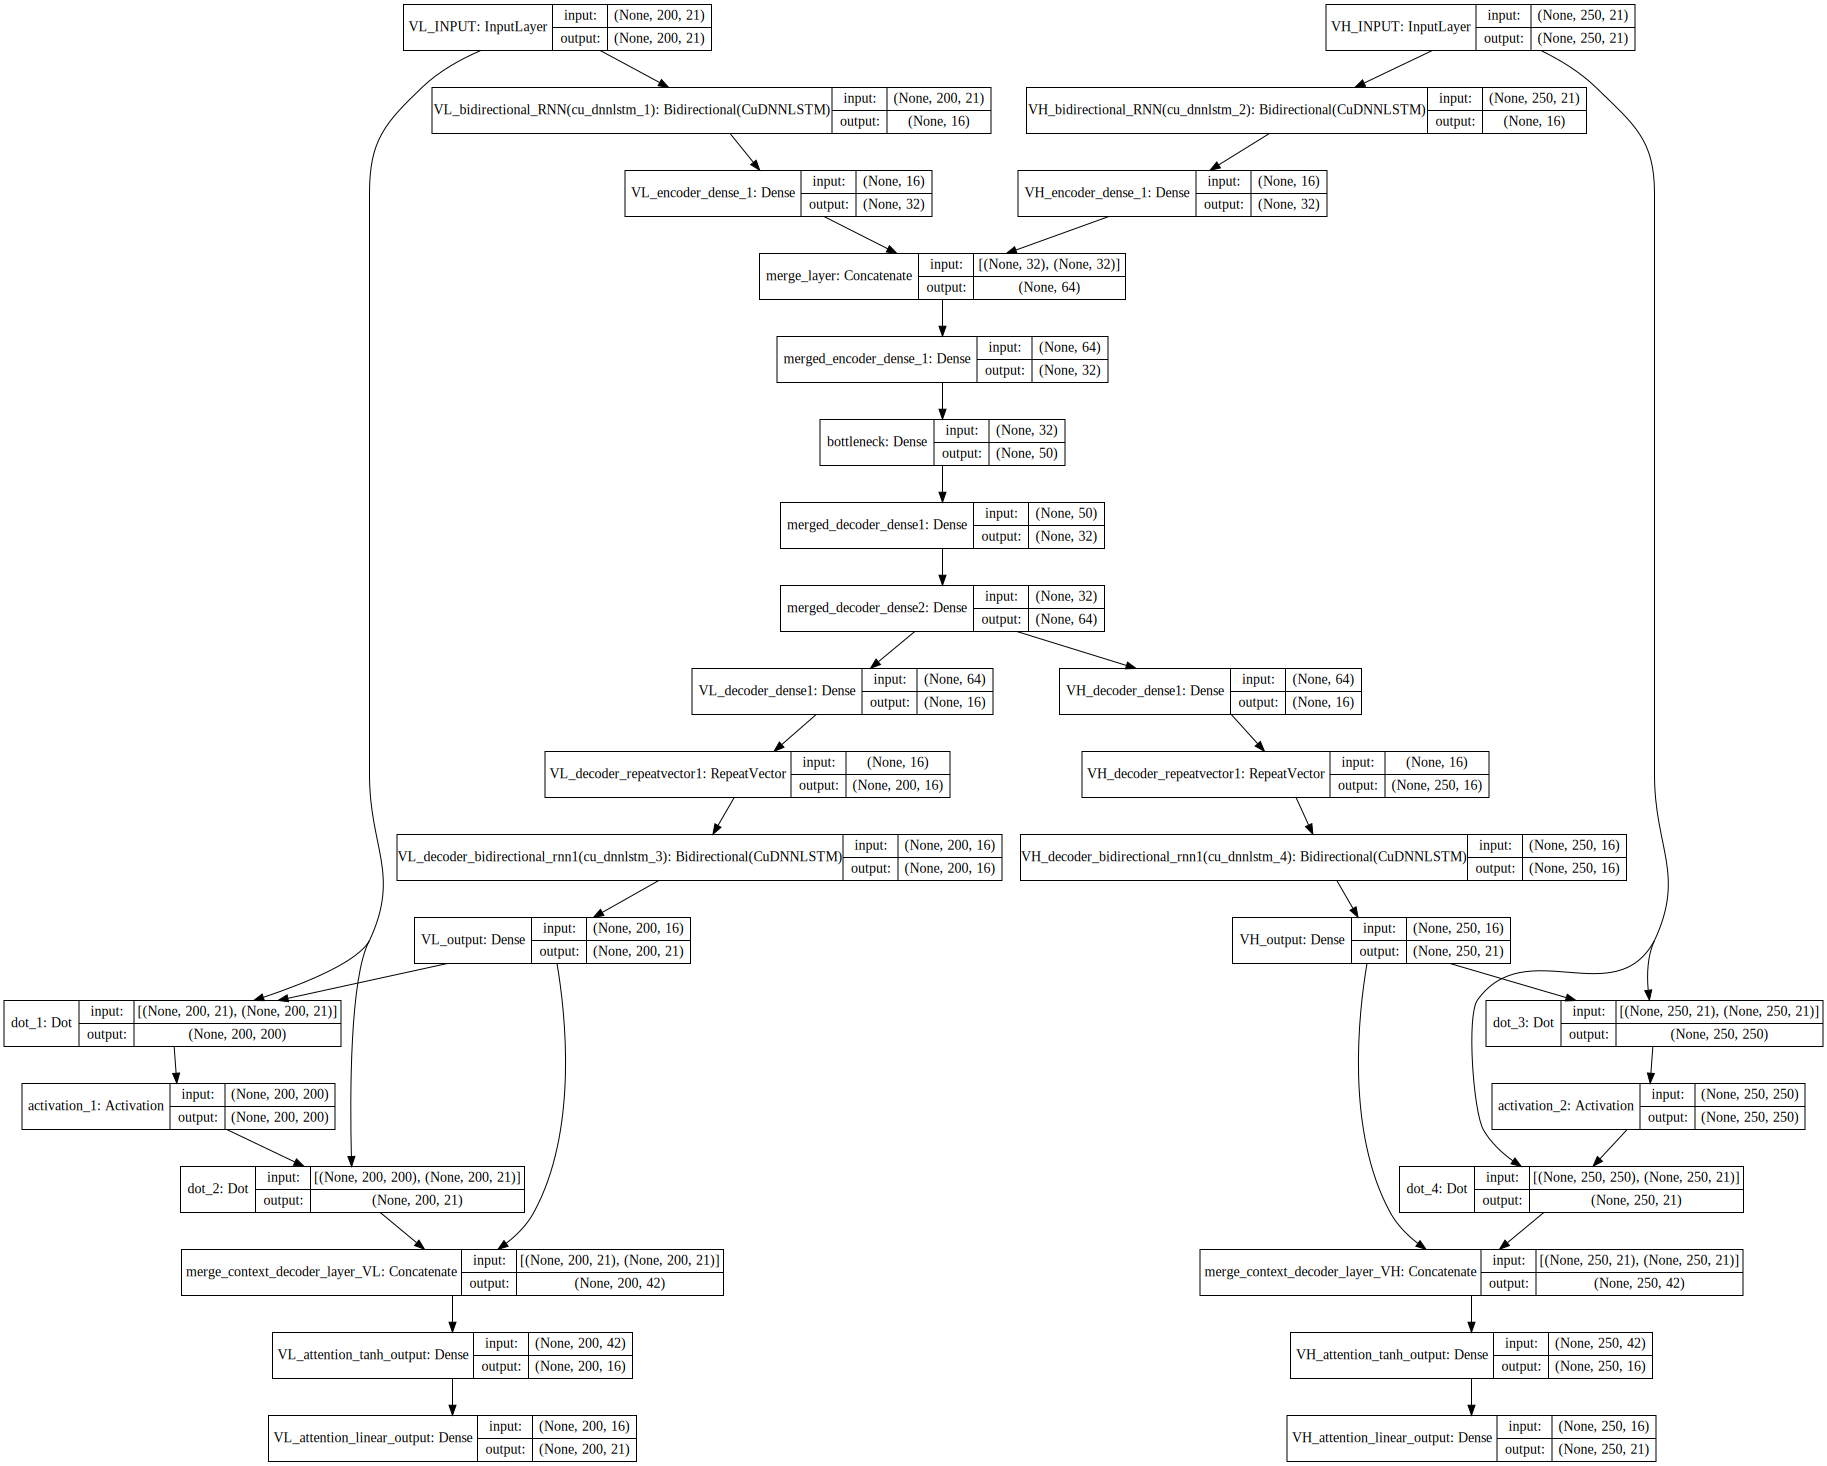

In [5]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VL_INPUT (InputLayer)           (None, 200, 21)      0                                            
__________________________________________________________________________________________________
VH_INPUT (InputLayer)           (None, 250, 21)      0                                            
__________________________________________________________________________________________________
VL_bidirectional_RNN (Bidirecti (None, 16)           4992        VL_INPUT[0][0]                   
__________________________________________________________________________________________________
VH_bidirectional_RNN (Bidirecti (None, 16)           4992        VH_INPUT[0][0]                   
__________________________________________________________________________________________________
VL_encoder

In [8]:
NAME= 'attention_autoencoder1_raw_lstm'
RUN = 'run2'

weight_path = '../model_weights/{}/{}/{}.hdf5'.format(NAME,RUN,NAME)
log_path = '../logs/{}/{}'.format(NAME, RUN)

In [9]:
if not os.path.exists('../model_weights/{}/{}/'.format(NAME,RUN)):
    if not os.path.exists('../model_weights/{}'.format(NAME)):
        os.mkdir('../model_weights/{}'.format(NAME))
    os.mkdir('../model_weights/{}/{}'.format(NAME,RUN))

In [10]:
from keras import backend as K

In [11]:
def get_loss(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.constant(mask_value, dtype=K.floatx())

    def masked_entropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())
        mask_sum = K.sum(mask)
        l=K.tf.contrib.seq2seq.sequence_loss(targets=K.argmax(y_true), logits=y_pred, weights=mask,
                                     average_across_batch=False, average_across_timesteps=False)
        return K.sum(l) / mask_sum
    return masked_entropy
    
lhs=K.placeholder((None,200,21))
rhs=K.placeholder((None,200,21))

func=get_loss(0)(lhs, rhs)
r=sess.run(func, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled[:1]})

In [12]:
def acc(y_true, y_pred):
    mask = K.all(K.equal(y_true, 0), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())
    mask_sum = K.sum(mask)
    acc = K.cast(K.equal(K.argmax(y_true), K.argmax(K.softmax(y_pred))), dtype=K.floatx()) * mask
    return K.sum(acc) / mask_sum

In [13]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=get_loss(0), metrics=[acc])

In [14]:
history = autoencoder.fit([VL_encoded_shuffled, VH_encoded_shuffled], [VL_encoded_shuffled, VH_encoded_shuffled],
                          epochs=5000, batch_size=32, validation_split=0.2,
                          callbacks=[keras.callbacks.ModelCheckpoint(weight_path, save_best_only=True),
                                     keras.callbacks.TensorBoard(log_path)])

Train on 4144 samples, validate on 1036 samples


W0417 16:32:31.039015 140154006140736 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name summary.merge_all is deprecated. Please use compat.v1.summary.merge_all instead.

W0417 16:32:31.039512 140154006140736 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name summary.FileWriter is deprecated. Please use compat.v1.summary.FileWriter instead.



Epoch 1/5000
4144/4144 [==============================] - 11s 3ms/step - loss: 5.6941 - VL_attention_linear_output_loss: 2.8271 - VH_attention_linear_output_loss: 2.8671 - VL_attention_linear_output_acc: 0.1395 - VH_attention_linear_output_acc: 0.1159 - val_loss: 5.6149 - val_VL_attention_linear_output_loss: 2.7906 - val_VH_attention_linear_output_loss: 2.8243 - val_VL_attention_linear_output_acc: 0.1474 - val_VH_attention_linear_output_acc: 0.1237
Epoch 2/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 5.5886 - VL_attention_linear_output_loss: 2.7780 - VH_attention_linear_output_loss: 2.8107 - VL_attention_linear_output_acc: 0.1497 - VH_attention_linear_output_acc: 0.1275 - val_loss: 5.5566 - val_VL_attention_linear_output_loss: 2.7628 - val_VH_attention_linear_output_loss: 2.7938 - val_VL_attention_linear_output_acc: 0.1571 - val_VH_attention_linear_output_acc: 0.1302
Epoch 3/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 5.5419 - VL_atten

4144/4144 [==============================] - 9s 2ms/step - loss: 4.7934 - VL_attention_linear_output_loss: 2.2200 - VH_attention_linear_output_loss: 2.5734 - VL_attention_linear_output_acc: 0.2945 - VH_attention_linear_output_acc: 0.1820 - val_loss: 4.7924 - val_VL_attention_linear_output_loss: 2.2290 - val_VH_attention_linear_output_loss: 2.5635 - val_VL_attention_linear_output_acc: 0.2800 - val_VH_attention_linear_output_acc: 0.1843
Epoch 38/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.7909 - VL_attention_linear_output_loss: 2.2238 - VH_attention_linear_output_loss: 2.5671 - VL_attention_linear_output_acc: 0.2945 - VH_attention_linear_output_acc: 0.1852 - val_loss: 4.7539 - val_VL_attention_linear_output_loss: 2.1968 - val_VH_attention_linear_output_loss: 2.5572 - val_VL_attention_linear_output_acc: 0.3076 - val_VH_attention_linear_output_acc: 0.1908
Epoch 39/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.7905 - VL_attention_linear_

4144/4144 [==============================] - 9s 2ms/step - loss: 4.5519 - VL_attention_linear_output_loss: 2.1209 - VH_attention_linear_output_loss: 2.4310 - VL_attention_linear_output_acc: 0.3381 - VH_attention_linear_output_acc: 0.2238 - val_loss: 4.6162 - val_VL_attention_linear_output_loss: 2.1926 - val_VH_attention_linear_output_loss: 2.4236 - val_VL_attention_linear_output_acc: 0.2980 - val_VH_attention_linear_output_acc: 0.2251
Epoch 74/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.5431 - VL_attention_linear_output_loss: 2.1144 - VH_attention_linear_output_loss: 2.4287 - VL_attention_linear_output_acc: 0.3410 - VH_attention_linear_output_acc: 0.2237 - val_loss: 4.5032 - val_VL_attention_linear_output_loss: 2.0833 - val_VH_attention_linear_output_loss: 2.4198 - val_VL_attention_linear_output_acc: 0.3570 - val_VH_attention_linear_output_acc: 0.2270
Epoch 75/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.5601 - VL_attention_linear_

Epoch 109/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.3868 - VL_attention_linear_output_loss: 2.0543 - VH_attention_linear_output_loss: 2.3325 - VL_attention_linear_output_acc: 0.3763 - VH_attention_linear_output_acc: 0.2530 - val_loss: 4.3503 - val_VL_attention_linear_output_loss: 2.0269 - val_VH_attention_linear_output_loss: 2.3234 - val_VL_attention_linear_output_acc: 0.3959 - val_VH_attention_linear_output_acc: 0.2559
Epoch 110/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.4084 - VL_attention_linear_output_loss: 2.0743 - VH_attention_linear_output_loss: 2.3341 - VL_attention_linear_output_acc: 0.3647 - VH_attention_linear_output_acc: 0.2525 - val_loss: 4.3500 - val_VL_attention_linear_output_loss: 2.0324 - val_VH_attention_linear_output_loss: 2.3175 - val_VL_attention_linear_output_acc: 0.3866 - val_VH_attention_linear_output_acc: 0.2648
Epoch 111/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.3802 - VL_

4144/4144 [==============================] - 9s 2ms/step - loss: 4.3067 - VL_attention_linear_output_loss: 2.0084 - VH_attention_linear_output_loss: 2.2983 - VL_attention_linear_output_acc: 0.3995 - VH_attention_linear_output_acc: 0.2716 - val_loss: 4.2785 - val_VL_attention_linear_output_loss: 1.9950 - val_VH_attention_linear_output_loss: 2.2834 - val_VL_attention_linear_output_acc: 0.4053 - val_VH_attention_linear_output_acc: 0.2797
Epoch 146/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2859 - VL_attention_linear_output_loss: 2.0019 - VH_attention_linear_output_loss: 2.2840 - VL_attention_linear_output_acc: 0.4021 - VH_attention_linear_output_acc: 0.2791 - val_loss: 4.2842 - val_VL_attention_linear_output_loss: 2.0036 - val_VH_attention_linear_output_loss: 2.2806 - val_VL_attention_linear_output_acc: 0.4039 - val_VH_attention_linear_output_acc: 0.2808
Epoch 147/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2845 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.2651 - VL_attention_linear_output_loss: 1.9966 - VH_attention_linear_output_loss: 2.2685 - VL_attention_linear_output_acc: 0.3950 - VH_attention_linear_output_acc: 0.2825 - val_loss: 4.2352 - val_VL_attention_linear_output_loss: 1.9782 - val_VH_attention_linear_output_loss: 2.2571 - val_VL_attention_linear_output_acc: 0.4107 - val_VH_attention_linear_output_acc: 0.2908
Epoch 182/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2535 - VL_attention_linear_output_loss: 1.9889 - VH_attention_linear_output_loss: 2.2646 - VL_attention_linear_output_acc: 0.4008 - VH_attention_linear_output_acc: 0.2864 - val_loss: 4.4618 - val_VL_attention_linear_output_loss: 2.1926 - val_VH_attention_linear_output_loss: 2.2692 - val_VL_attention_linear_output_acc: 0.3037 - val_VH_attention_linear_output_acc: 0.2831
Epoch 183/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2559 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.2048 - VL_attention_linear_output_loss: 1.9627 - VH_attention_linear_output_loss: 2.2421 - VL_attention_linear_output_acc: 0.4041 - VH_attention_linear_output_acc: 0.2958 - val_loss: 4.1889 - val_VL_attention_linear_output_loss: 1.9502 - val_VH_attention_linear_output_loss: 2.2387 - val_VL_attention_linear_output_acc: 0.4110 - val_VH_attention_linear_output_acc: 0.3010
Epoch 218/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2123 - VL_attention_linear_output_loss: 1.9689 - VH_attention_linear_output_loss: 2.2435 - VL_attention_linear_output_acc: 0.4011 - VH_attention_linear_output_acc: 0.2954 - val_loss: 4.1854 - val_VL_attention_linear_output_loss: 1.9467 - val_VH_attention_linear_output_loss: 2.2388 - val_VL_attention_linear_output_acc: 0.4136 - val_VH_attention_linear_output_acc: 0.3011
Epoch 219/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2111 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.1768 - VL_attention_linear_output_loss: 1.9546 - VH_attention_linear_output_loss: 2.2222 - VL_attention_linear_output_acc: 0.4029 - VH_attention_linear_output_acc: 0.3048 - val_loss: 4.1578 - val_VL_attention_linear_output_loss: 1.9343 - val_VH_attention_linear_output_loss: 2.2235 - val_VL_attention_linear_output_acc: 0.4164 - val_VH_attention_linear_output_acc: 0.3039
Epoch 254/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1587 - VL_attention_linear_output_loss: 1.9386 - VH_attention_linear_output_loss: 2.2201 - VL_attention_linear_output_acc: 0.4114 - VH_attention_linear_output_acc: 0.3053 - val_loss: 4.1857 - val_VL_attention_linear_output_loss: 1.9703 - val_VH_attention_linear_output_loss: 2.2154 - val_VL_attention_linear_output_acc: 0.3891 - val_VH_attention_linear_output_acc: 0.3074
Epoch 255/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1782 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.1275 - VL_attention_linear_output_loss: 1.9289 - VH_attention_linear_output_loss: 2.1987 - VL_attention_linear_output_acc: 0.4137 - VH_attention_linear_output_acc: 0.3159 - val_loss: 4.1459 - val_VL_attention_linear_output_loss: 1.9247 - val_VH_attention_linear_output_loss: 2.2212 - val_VL_attention_linear_output_acc: 0.4082 - val_VH_attention_linear_output_acc: 0.3009
Epoch 290/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1257 - VL_attention_linear_output_loss: 1.9257 - VH_attention_linear_output_loss: 2.2000 - VL_attention_linear_output_acc: 0.4133 - VH_attention_linear_output_acc: 0.3146 - val_loss: 4.1898 - val_VL_attention_linear_output_loss: 1.9847 - val_VH_attention_linear_output_loss: 2.2051 - val_VL_attention_linear_output_acc: 0.3793 - val_VH_attention_linear_output_acc: 0.3190
Epoch 291/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1325 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.1074 - VL_attention_linear_output_loss: 1.9239 - VH_attention_linear_output_loss: 2.1835 - VL_attention_linear_output_acc: 0.4172 - VH_attention_linear_output_acc: 0.3191 - val_loss: 4.0937 - val_VL_attention_linear_output_loss: 1.9075 - val_VH_attention_linear_output_loss: 2.1862 - val_VL_attention_linear_output_acc: 0.4223 - val_VH_attention_linear_output_acc: 0.3128
Epoch 326/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1107 - VL_attention_linear_output_loss: 1.9298 - VH_attention_linear_output_loss: 2.1808 - VL_attention_linear_output_acc: 0.4150 - VH_attention_linear_output_acc: 0.3208 - val_loss: 4.1125 - val_VL_attention_linear_output_loss: 1.9308 - val_VH_attention_linear_output_loss: 2.1817 - val_VL_attention_linear_output_acc: 0.4203 - val_VH_attention_linear_output_acc: 0.3149
Epoch 327/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0927 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.0855 - VL_attention_linear_output_loss: 1.9009 - VH_attention_linear_output_loss: 2.1847 - VL_attention_linear_output_acc: 0.4316 - VH_attention_linear_output_acc: 0.3211 - val_loss: 4.0856 - val_VL_attention_linear_output_loss: 1.9004 - val_VH_attention_linear_output_loss: 2.1852 - val_VL_attention_linear_output_acc: 0.4377 - val_VH_attention_linear_output_acc: 0.3201
Epoch 362/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0914 - VL_attention_linear_output_loss: 1.9073 - VH_attention_linear_output_loss: 2.1840 - VL_attention_linear_output_acc: 0.4282 - VH_attention_linear_output_acc: 0.3200 - val_loss: 4.0962 - val_VL_attention_linear_output_loss: 1.9002 - val_VH_attention_linear_output_loss: 2.1960 - val_VL_attention_linear_output_acc: 0.4337 - val_VH_attention_linear_output_acc: 0.3134
Epoch 363/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0733 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.0758 - VL_attention_linear_output_loss: 1.8942 - VH_attention_linear_output_loss: 2.1817 - VL_attention_linear_output_acc: 0.4351 - VH_attention_linear_output_acc: 0.3208 - val_loss: 4.0670 - val_VL_attention_linear_output_loss: 1.9028 - val_VH_attention_linear_output_loss: 2.1642 - val_VL_attention_linear_output_acc: 0.4384 - val_VH_attention_linear_output_acc: 0.3279
Epoch 398/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0509 - VL_attention_linear_output_loss: 1.8857 - VH_attention_linear_output_loss: 2.1652 - VL_attention_linear_output_acc: 0.4388 - VH_attention_linear_output_acc: 0.3284 - val_loss: 4.0577 - val_VL_attention_linear_output_loss: 1.8919 - val_VH_attention_linear_output_loss: 2.1658 - val_VL_attention_linear_output_acc: 0.4450 - val_VH_attention_linear_output_acc: 0.3243
Epoch 399/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0461 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.0379 - VL_attention_linear_output_loss: 1.8845 - VH_attention_linear_output_loss: 2.1534 - VL_attention_linear_output_acc: 0.4412 - VH_attention_linear_output_acc: 0.3297 - val_loss: 4.0508 - val_VL_attention_linear_output_loss: 1.8730 - val_VH_attention_linear_output_loss: 2.1777 - val_VL_attention_linear_output_acc: 0.4524 - val_VH_attention_linear_output_acc: 0.3094
Epoch 434/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0247 - VL_attention_linear_output_loss: 1.8698 - VH_attention_linear_output_loss: 2.1549 - VL_attention_linear_output_acc: 0.4499 - VH_attention_linear_output_acc: 0.3288 - val_loss: 4.0300 - val_VL_attention_linear_output_loss: 1.8773 - val_VH_attention_linear_output_loss: 2.1527 - val_VL_attention_linear_output_acc: 0.4558 - val_VH_attention_linear_output_acc: 0.3238
Epoch 435/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0326 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.2049 - VL_attention_linear_output_loss: 1.8690 - VH_attention_linear_output_loss: 2.3359 - VL_attention_linear_output_acc: 0.4509 - VH_attention_linear_output_acc: 0.2924 - val_loss: 4.6194 - val_VL_attention_linear_output_loss: 1.8998 - val_VH_attention_linear_output_loss: 2.7196 - val_VL_attention_linear_output_acc: 0.4518 - val_VH_attention_linear_output_acc: 0.2282
Epoch 470/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.4051 - VL_attention_linear_output_loss: 1.8811 - VH_attention_linear_output_loss: 2.5239 - VL_attention_linear_output_acc: 0.4461 - VH_attention_linear_output_acc: 0.2545 - val_loss: 4.3072 - val_VL_attention_linear_output_loss: 1.8621 - val_VH_attention_linear_output_loss: 2.4451 - val_VL_attention_linear_output_acc: 0.4562 - val_VH_attention_linear_output_acc: 0.2628
Epoch 471/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.2849 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.0050 - VL_attention_linear_output_loss: 1.8531 - VH_attention_linear_output_loss: 2.1518 - VL_attention_linear_output_acc: 0.4581 - VH_attention_linear_output_acc: 0.3259 - val_loss: 3.9968 - val_VL_attention_linear_output_loss: 1.8486 - val_VH_attention_linear_output_loss: 2.1482 - val_VL_attention_linear_output_acc: 0.4708 - val_VH_attention_linear_output_acc: 0.3250
Epoch 506/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0039 - VL_attention_linear_output_loss: 1.8539 - VH_attention_linear_output_loss: 2.1500 - VL_attention_linear_output_acc: 0.4585 - VH_attention_linear_output_acc: 0.3269 - val_loss: 4.0261 - val_VL_attention_linear_output_loss: 1.8771 - val_VH_attention_linear_output_loss: 2.1490 - val_VL_attention_linear_output_acc: 0.4469 - val_VH_attention_linear_output_acc: 0.3256
Epoch 507/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0113 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9836 - VL_attention_linear_output_loss: 1.8486 - VH_attention_linear_output_loss: 2.1351 - VL_attention_linear_output_acc: 0.4593 - VH_attention_linear_output_acc: 0.3313 - val_loss: 4.0190 - val_VL_attention_linear_output_loss: 1.8697 - val_VH_attention_linear_output_loss: 2.1493 - val_VL_attention_linear_output_acc: 0.4467 - val_VH_attention_linear_output_acc: 0.3209
Epoch 542/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9721 - VL_attention_linear_output_loss: 1.8360 - VH_attention_linear_output_loss: 2.1361 - VL_attention_linear_output_acc: 0.4653 - VH_attention_linear_output_acc: 0.3302 - val_loss: 4.0071 - val_VL_attention_linear_output_loss: 1.8500 - val_VH_attention_linear_output_loss: 2.1570 - val_VL_attention_linear_output_acc: 0.4638 - val_VH_attention_linear_output_acc: 0.3131
Epoch 543/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9686 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9474 - VL_attention_linear_output_loss: 1.8290 - VH_attention_linear_output_loss: 2.1184 - VL_attention_linear_output_acc: 0.4686 - VH_attention_linear_output_acc: 0.3371 - val_loss: 3.9551 - val_VL_attention_linear_output_loss: 1.8401 - val_VH_attention_linear_output_loss: 2.1150 - val_VL_attention_linear_output_acc: 0.4665 - val_VH_attention_linear_output_acc: 0.3402
Epoch 578/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9669 - VL_attention_linear_output_loss: 1.8440 - VH_attention_linear_output_loss: 2.1229 - VL_attention_linear_output_acc: 0.4585 - VH_attention_linear_output_acc: 0.3333 - val_loss: 3.9782 - val_VL_attention_linear_output_loss: 1.8559 - val_VH_attention_linear_output_loss: 2.1223 - val_VL_attention_linear_output_acc: 0.4637 - val_VH_attention_linear_output_acc: 0.3359
Epoch 579/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9514 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9581 - VL_attention_linear_output_loss: 1.8441 - VH_attention_linear_output_loss: 2.1140 - VL_attention_linear_output_acc: 0.4592 - VH_attention_linear_output_acc: 0.3400 - val_loss: 3.9797 - val_VL_attention_linear_output_loss: 1.8650 - val_VH_attention_linear_output_loss: 2.1148 - val_VL_attention_linear_output_acc: 0.4504 - val_VH_attention_linear_output_acc: 0.3362
Epoch 614/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9281 - VL_attention_linear_output_loss: 1.8259 - VH_attention_linear_output_loss: 2.1022 - VL_attention_linear_output_acc: 0.4687 - VH_attention_linear_output_acc: 0.3453 - val_loss: 3.9474 - val_VL_attention_linear_output_loss: 1.8479 - val_VH_attention_linear_output_loss: 2.0994 - val_VL_attention_linear_output_acc: 0.4586 - val_VH_attention_linear_output_acc: 0.3492
Epoch 615/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9228 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9316 - VL_attention_linear_output_loss: 1.8357 - VH_attention_linear_output_loss: 2.0960 - VL_attention_linear_output_acc: 0.4635 - VH_attention_linear_output_acc: 0.3451 - val_loss: 3.9336 - val_VL_attention_linear_output_loss: 1.8390 - val_VH_attention_linear_output_loss: 2.0946 - val_VL_attention_linear_output_acc: 0.4625 - val_VH_attention_linear_output_acc: 0.3468
Epoch 650/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9128 - VL_attention_linear_output_loss: 1.8189 - VH_attention_linear_output_loss: 2.0939 - VL_attention_linear_output_acc: 0.4723 - VH_attention_linear_output_acc: 0.3457 - val_loss: 3.9568 - val_VL_attention_linear_output_loss: 1.8627 - val_VH_attention_linear_output_loss: 2.0941 - val_VL_attention_linear_output_acc: 0.4516 - val_VH_attention_linear_output_acc: 0.3440
Epoch 651/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9324 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9241 - VL_attention_linear_output_loss: 1.8374 - VH_attention_linear_output_loss: 2.0867 - VL_attention_linear_output_acc: 0.4612 - VH_attention_linear_output_acc: 0.3527 - val_loss: 3.9997 - val_VL_attention_linear_output_loss: 1.8673 - val_VH_attention_linear_output_loss: 2.1324 - val_VL_attention_linear_output_acc: 0.4511 - val_VH_attention_linear_output_acc: 0.3299
Epoch 686/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8988 - VL_attention_linear_output_loss: 1.8161 - VH_attention_linear_output_loss: 2.0827 - VL_attention_linear_output_acc: 0.4710 - VH_attention_linear_output_acc: 0.3556 - val_loss: 3.9240 - val_VL_attention_linear_output_loss: 1.8353 - val_VH_attention_linear_output_loss: 2.0887 - val_VL_attention_linear_output_acc: 0.4659 - val_VH_attention_linear_output_acc: 0.3494
Epoch 687/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9034 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 4.1663 - VL_attention_linear_output_loss: 1.8297 - VH_attention_linear_output_loss: 2.3366 - VL_attention_linear_output_acc: 0.4660 - VH_attention_linear_output_acc: 0.2879 - val_loss: 4.1814 - val_VL_attention_linear_output_loss: 1.8397 - val_VH_attention_linear_output_loss: 2.3416 - val_VL_attention_linear_output_acc: 0.4670 - val_VH_attention_linear_output_acc: 0.2764
Epoch 722/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1444 - VL_attention_linear_output_loss: 1.8366 - VH_attention_linear_output_loss: 2.3077 - VL_attention_linear_output_acc: 0.4621 - VH_attention_linear_output_acc: 0.2944 - val_loss: 4.1136 - val_VL_attention_linear_output_loss: 1.8333 - val_VH_attention_linear_output_loss: 2.2803 - val_VL_attention_linear_output_acc: 0.4672 - val_VH_attention_linear_output_acc: 0.3019
Epoch 723/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.1050 - VL_attention_linea

Epoch 739/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0066 - VL_attention_linear_output_loss: 1.8248 - VH_attention_linear_output_loss: 2.1819 - VL_attention_linear_output_acc: 0.4676 - VH_attention_linear_output_acc: 0.3378 - val_loss: 4.0996 - val_VL_attention_linear_output_loss: 1.9074 - val_VH_attention_linear_output_loss: 2.1922 - val_VL_attention_linear_output_acc: 0.4299 - val_VH_attention_linear_output_acc: 0.3331
Epoch 740/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 4.0120 - VL_attention_linear_output_loss: 1.8351 - VH_attention_linear_output_loss: 2.1769 - VL_attention_linear_output_acc: 0.4623 - VH_attention_linear_output_acc: 0.3397 - val_loss: 3.9969 - val_VL_attention_linear_output_loss: 1.8330 - val_VH_attention_linear_output_loss: 2.1639 - val_VL_attention_linear_output_acc: 0.4704 - val_VH_attention_linear_output_acc: 0.3449
Epoch 741/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9790 - VL_

4144/4144 [==============================] - 9s 2ms/step - loss: 3.9176 - VL_attention_linear_output_loss: 1.8134 - VH_attention_linear_output_loss: 2.1042 - VL_attention_linear_output_acc: 0.4722 - VH_attention_linear_output_acc: 0.3576 - val_loss: 3.9414 - val_VL_attention_linear_output_loss: 1.8254 - val_VH_attention_linear_output_loss: 2.1160 - val_VL_attention_linear_output_acc: 0.4746 - val_VH_attention_linear_output_acc: 0.3540
Epoch 776/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9373 - VL_attention_linear_output_loss: 1.8282 - VH_attention_linear_output_loss: 2.1090 - VL_attention_linear_output_acc: 0.4645 - VH_attention_linear_output_acc: 0.3542 - val_loss: 3.9377 - val_VL_attention_linear_output_loss: 1.8308 - val_VH_attention_linear_output_loss: 2.1069 - val_VL_attention_linear_output_acc: 0.4693 - val_VH_attention_linear_output_acc: 0.3527
Epoch 777/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.9184 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.8680 - VL_attention_linear_output_loss: 1.8034 - VH_attention_linear_output_loss: 2.0645 - VL_attention_linear_output_acc: 0.4751 - VH_attention_linear_output_acc: 0.3771 - val_loss: 3.9060 - val_VL_attention_linear_output_loss: 1.8272 - val_VH_attention_linear_output_loss: 2.0788 - val_VL_attention_linear_output_acc: 0.4654 - val_VH_attention_linear_output_acc: 0.3716
Epoch 812/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8798 - VL_attention_linear_output_loss: 1.8105 - VH_attention_linear_output_loss: 2.0694 - VL_attention_linear_output_acc: 0.4717 - VH_attention_linear_output_acc: 0.3743 - val_loss: 3.9022 - val_VL_attention_linear_output_loss: 1.8274 - val_VH_attention_linear_output_loss: 2.0749 - val_VL_attention_linear_output_acc: 0.4699 - val_VH_attention_linear_output_acc: 0.3712
Epoch 813/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8871 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.8498 - VL_attention_linear_output_loss: 1.8117 - VH_attention_linear_output_loss: 2.0381 - VL_attention_linear_output_acc: 0.4712 - VH_attention_linear_output_acc: 0.3805 - val_loss: 3.8723 - val_VL_attention_linear_output_loss: 1.8297 - val_VH_attention_linear_output_loss: 2.0426 - val_VL_attention_linear_output_acc: 0.4765 - val_VH_attention_linear_output_acc: 0.3789
Epoch 848/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8392 - VL_attention_linear_output_loss: 1.7996 - VH_attention_linear_output_loss: 2.0395 - VL_attention_linear_output_acc: 0.4764 - VH_attention_linear_output_acc: 0.3787 - val_loss: 3.9320 - val_VL_attention_linear_output_loss: 1.8224 - val_VH_attention_linear_output_loss: 2.1096 - val_VL_attention_linear_output_acc: 0.4700 - val_VH_attention_linear_output_acc: 0.3398
Epoch 849/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8511 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.8161 - VL_attention_linear_output_loss: 1.8000 - VH_attention_linear_output_loss: 2.0161 - VL_attention_linear_output_acc: 0.4735 - VH_attention_linear_output_acc: 0.3832 - val_loss: 3.8626 - val_VL_attention_linear_output_loss: 1.8278 - val_VH_attention_linear_output_loss: 2.0348 - val_VL_attention_linear_output_acc: 0.4644 - val_VH_attention_linear_output_acc: 0.3767
Epoch 884/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8278 - VL_attention_linear_output_loss: 1.8032 - VH_attention_linear_output_loss: 2.0246 - VL_attention_linear_output_acc: 0.4718 - VH_attention_linear_output_acc: 0.3806 - val_loss: 3.9050 - val_VL_attention_linear_output_loss: 1.8892 - val_VH_attention_linear_output_loss: 2.0158 - val_VL_attention_linear_output_acc: 0.4396 - val_VH_attention_linear_output_acc: 0.3842
Epoch 885/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8265 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7982 - VL_attention_linear_output_loss: 1.7909 - VH_attention_linear_output_loss: 2.0073 - VL_attention_linear_output_acc: 0.4778 - VH_attention_linear_output_acc: 0.3835 - val_loss: 3.8231 - val_VL_attention_linear_output_loss: 1.8152 - val_VH_attention_linear_output_loss: 2.0079 - val_VL_attention_linear_output_acc: 0.4747 - val_VH_attention_linear_output_acc: 0.3844
Epoch 920/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7944 - VL_attention_linear_output_loss: 1.7933 - VH_attention_linear_output_loss: 2.0011 - VL_attention_linear_output_acc: 0.4767 - VH_attention_linear_output_acc: 0.3861 - val_loss: 3.8431 - val_VL_attention_linear_output_loss: 1.8147 - val_VH_attention_linear_output_loss: 2.0284 - val_VL_attention_linear_output_acc: 0.4753 - val_VH_attention_linear_output_acc: 0.3700
Epoch 921/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8171 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7915 - VL_attention_linear_output_loss: 1.7956 - VH_attention_linear_output_loss: 1.9959 - VL_attention_linear_output_acc: 0.4731 - VH_attention_linear_output_acc: 0.3875 - val_loss: 3.8127 - val_VL_attention_linear_output_loss: 1.8125 - val_VH_attention_linear_output_loss: 2.0002 - val_VL_attention_linear_output_acc: 0.4718 - val_VH_attention_linear_output_acc: 0.3870
Epoch 956/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.8097 - VL_attention_linear_output_loss: 1.8135 - VH_attention_linear_output_loss: 1.9962 - VL_attention_linear_output_acc: 0.4703 - VH_attention_linear_output_acc: 0.3871 - val_loss: 3.8927 - val_VL_attention_linear_output_loss: 1.8923 - val_VH_attention_linear_output_loss: 2.0004 - val_VL_attention_linear_output_acc: 0.4305 - val_VH_attention_linear_output_acc: 0.3853
Epoch 957/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7973 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7704 - VL_attention_linear_output_loss: 1.7889 - VH_attention_linear_output_loss: 1.9815 - VL_attention_linear_output_acc: 0.4764 - VH_attention_linear_output_acc: 0.3932 - val_loss: 3.7973 - val_VL_attention_linear_output_loss: 1.8173 - val_VH_attention_linear_output_loss: 1.9800 - val_VL_attention_linear_output_acc: 0.4742 - val_VH_attention_linear_output_acc: 0.3927
Epoch 992/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7678 - VL_attention_linear_output_loss: 1.7907 - VH_attention_linear_output_loss: 1.9771 - VL_attention_linear_output_acc: 0.4760 - VH_attention_linear_output_acc: 0.3949 - val_loss: 3.7925 - val_VL_attention_linear_output_loss: 1.8125 - val_VH_attention_linear_output_loss: 1.9800 - val_VL_attention_linear_output_acc: 0.4727 - val_VH_attention_linear_output_acc: 0.3928
Epoch 993/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7887 - VL_attention_linea

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7814 - VL_attention_linear_output_loss: 1.8051 - VH_attention_linear_output_loss: 1.9764 - VL_attention_linear_output_acc: 0.4698 - VH_attention_linear_output_acc: 0.3982 - val_loss: 3.8120 - val_VL_attention_linear_output_loss: 1.8142 - val_VH_attention_linear_output_loss: 1.9977 - val_VL_attention_linear_output_acc: 0.4689 - val_VH_attention_linear_output_acc: 0.3898
Epoch 1028/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7532 - VL_attention_linear_output_loss: 1.7838 - VH_attention_linear_output_loss: 1.9694 - VL_attention_linear_output_acc: 0.4795 - VH_attention_linear_output_acc: 0.3994 - val_loss: 3.8066 - val_VL_attention_linear_output_loss: 1.8098 - val_VH_attention_linear_output_loss: 1.9968 - val_VL_attention_linear_output_acc: 0.4756 - val_VH_attention_linear_output_acc: 0.3883
Epoch 1029/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7623 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7679 - VL_attention_linear_output_loss: 1.8037 - VH_attention_linear_output_loss: 1.9642 - VL_attention_linear_output_acc: 0.4679 - VH_attention_linear_output_acc: 0.4024 - val_loss: 3.7894 - val_VL_attention_linear_output_loss: 1.8219 - val_VH_attention_linear_output_loss: 1.9675 - val_VL_attention_linear_output_acc: 0.4683 - val_VH_attention_linear_output_acc: 0.4026
Epoch 1064/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7416 - VL_attention_linear_output_loss: 1.7816 - VH_attention_linear_output_loss: 1.9599 - VL_attention_linear_output_acc: 0.4796 - VH_attention_linear_output_acc: 0.4044 - val_loss: 3.7687 - val_VL_attention_linear_output_loss: 1.8034 - val_VH_attention_linear_output_loss: 1.9653 - val_VL_attention_linear_output_acc: 0.4781 - val_VH_attention_linear_output_acc: 0.4028
Epoch 1065/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7550 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7704 - VL_attention_linear_output_loss: 1.8054 - VH_attention_linear_output_loss: 1.9650 - VL_attention_linear_output_acc: 0.4672 - VH_attention_linear_output_acc: 0.4024 - val_loss: 3.8563 - val_VL_attention_linear_output_loss: 1.8855 - val_VH_attention_linear_output_loss: 1.9708 - val_VL_attention_linear_output_acc: 0.4385 - val_VH_attention_linear_output_acc: 0.3993
Epoch 1100/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7472 - VL_attention_linear_output_loss: 1.7874 - VH_attention_linear_output_loss: 1.9598 - VL_attention_linear_output_acc: 0.4759 - VH_attention_linear_output_acc: 0.4035 - val_loss: 3.7553 - val_VL_attention_linear_output_loss: 1.8002 - val_VH_attention_linear_output_loss: 1.9551 - val_VL_attention_linear_output_acc: 0.4803 - val_VH_attention_linear_output_acc: 0.4067
Epoch 1101/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7388 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7281 - VL_attention_linear_output_loss: 1.7831 - VH_attention_linear_output_loss: 1.9450 - VL_attention_linear_output_acc: 0.4785 - VH_attention_linear_output_acc: 0.4091 - val_loss: 3.7831 - val_VL_attention_linear_output_loss: 1.8091 - val_VH_attention_linear_output_loss: 1.9739 - val_VL_attention_linear_output_acc: 0.4836 - val_VH_attention_linear_output_acc: 0.3974
Epoch 1136/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7409 - VL_attention_linear_output_loss: 1.7876 - VH_attention_linear_output_loss: 1.9533 - VL_attention_linear_output_acc: 0.4770 - VH_attention_linear_output_acc: 0.4053 - val_loss: 3.8300 - val_VL_attention_linear_output_loss: 1.8118 - val_VH_attention_linear_output_loss: 2.0182 - val_VL_attention_linear_output_acc: 0.4718 - val_VH_attention_linear_output_acc: 0.3792
Epoch 1137/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7380 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7260 - VL_attention_linear_output_loss: 1.7813 - VH_attention_linear_output_loss: 1.9447 - VL_attention_linear_output_acc: 0.4785 - VH_attention_linear_output_acc: 0.4074 - val_loss: 3.7884 - val_VL_attention_linear_output_loss: 1.8174 - val_VH_attention_linear_output_loss: 1.9710 - val_VL_attention_linear_output_acc: 0.4662 - val_VH_attention_linear_output_acc: 0.4003
Epoch 1172/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7595 - VL_attention_linear_output_loss: 1.8067 - VH_attention_linear_output_loss: 1.9528 - VL_attention_linear_output_acc: 0.4663 - VH_attention_linear_output_acc: 0.4046 - val_loss: 3.7677 - val_VL_attention_linear_output_loss: 1.8009 - val_VH_attention_linear_output_loss: 1.9668 - val_VL_attention_linear_output_acc: 0.4746 - val_VH_attention_linear_output_acc: 0.4005
Epoch 1173/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7091 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7211 - VL_attention_linear_output_loss: 1.7885 - VH_attention_linear_output_loss: 1.9326 - VL_attention_linear_output_acc: 0.4743 - VH_attention_linear_output_acc: 0.4097 - val_loss: 3.7440 - val_VL_attention_linear_output_loss: 1.8053 - val_VH_attention_linear_output_loss: 1.9387 - val_VL_attention_linear_output_acc: 0.4718 - val_VH_attention_linear_output_acc: 0.4115
Epoch 1208/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7109 - VL_attention_linear_output_loss: 1.7820 - VH_attention_linear_output_loss: 1.9288 - VL_attention_linear_output_acc: 0.4767 - VH_attention_linear_output_acc: 0.4121 - val_loss: 3.7623 - val_VL_attention_linear_output_loss: 1.8003 - val_VH_attention_linear_output_loss: 1.9620 - val_VL_attention_linear_output_acc: 0.4776 - val_VH_attention_linear_output_acc: 0.3950
Epoch 1209/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7228 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7193 - VL_attention_linear_output_loss: 1.7933 - VH_attention_linear_output_loss: 1.9260 - VL_attention_linear_output_acc: 0.4717 - VH_attention_linear_output_acc: 0.4120 - val_loss: 3.7376 - val_VL_attention_linear_output_loss: 1.8074 - val_VH_attention_linear_output_loss: 1.9302 - val_VL_attention_linear_output_acc: 0.4710 - val_VH_attention_linear_output_acc: 0.4123
Epoch 1244/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6984 - VL_attention_linear_output_loss: 1.7772 - VH_attention_linear_output_loss: 1.9213 - VL_attention_linear_output_acc: 0.4783 - VH_attention_linear_output_acc: 0.4139 - val_loss: 3.7333 - val_VL_attention_linear_output_loss: 1.7996 - val_VH_attention_linear_output_loss: 1.9337 - val_VL_attention_linear_output_acc: 0.4773 - val_VH_attention_linear_output_acc: 0.4106
Epoch 1245/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.7033 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.7020 - VL_attention_linear_output_loss: 1.7859 - VH_attention_linear_output_loss: 1.9161 - VL_attention_linear_output_acc: 0.4745 - VH_attention_linear_output_acc: 0.4152 - val_loss: 3.7797 - val_VL_attention_linear_output_loss: 1.8266 - val_VH_attention_linear_output_loss: 1.9530 - val_VL_attention_linear_output_acc: 0.4572 - val_VH_attention_linear_output_acc: 0.4080
Epoch 1280/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6950 - VL_attention_linear_output_loss: 1.7759 - VH_attention_linear_output_loss: 1.9191 - VL_attention_linear_output_acc: 0.4800 - VH_attention_linear_output_acc: 0.4141 - val_loss: 3.7324 - val_VL_attention_linear_output_loss: 1.8078 - val_VH_attention_linear_output_loss: 1.9246 - val_VL_attention_linear_output_acc: 0.4717 - val_VH_attention_linear_output_acc: 0.4164
Epoch 1281/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6888 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6835 - VL_attention_linear_output_loss: 1.7689 - VH_attention_linear_output_loss: 1.9146 - VL_attention_linear_output_acc: 0.4836 - VH_attention_linear_output_acc: 0.4160 - val_loss: 3.7176 - val_VL_attention_linear_output_loss: 1.7974 - val_VH_attention_linear_output_loss: 1.9203 - val_VL_attention_linear_output_acc: 0.4802 - val_VH_attention_linear_output_acc: 0.4185
Epoch 1316/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6860 - VL_attention_linear_output_loss: 1.7711 - VH_attention_linear_output_loss: 1.9149 - VL_attention_linear_output_acc: 0.4816 - VH_attention_linear_output_acc: 0.4157 - val_loss: 3.7644 - val_VL_attention_linear_output_loss: 1.8485 - val_VH_attention_linear_output_loss: 1.9159 - val_VL_attention_linear_output_acc: 0.4527 - val_VH_attention_linear_output_acc: 0.4169
Epoch 1317/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6858 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6779 - VL_attention_linear_output_loss: 1.7804 - VH_attention_linear_output_loss: 1.8976 - VL_attention_linear_output_acc: 0.4765 - VH_attention_linear_output_acc: 0.4226 - val_loss: 3.7273 - val_VL_attention_linear_output_loss: 1.7940 - val_VH_attention_linear_output_loss: 1.9333 - val_VL_attention_linear_output_acc: 0.4821 - val_VH_attention_linear_output_acc: 0.4157
Epoch 1352/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6723 - VL_attention_linear_output_loss: 1.7660 - VH_attention_linear_output_loss: 1.9063 - VL_attention_linear_output_acc: 0.4817 - VH_attention_linear_output_acc: 0.4192 - val_loss: 3.7321 - val_VL_attention_linear_output_loss: 1.7994 - val_VH_attention_linear_output_loss: 1.9326 - val_VL_attention_linear_output_acc: 0.4803 - val_VH_attention_linear_output_acc: 0.4096
Epoch 1353/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6793 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6749 - VL_attention_linear_output_loss: 1.7782 - VH_attention_linear_output_loss: 1.8967 - VL_attention_linear_output_acc: 0.4787 - VH_attention_linear_output_acc: 0.4226 - val_loss: 3.7190 - val_VL_attention_linear_output_loss: 1.8098 - val_VH_attention_linear_output_loss: 1.9092 - val_VL_attention_linear_output_acc: 0.4671 - val_VH_attention_linear_output_acc: 0.4200
Epoch 1388/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6886 - VL_attention_linear_output_loss: 1.7949 - VH_attention_linear_output_loss: 1.8938 - VL_attention_linear_output_acc: 0.4690 - VH_attention_linear_output_acc: 0.4236 - val_loss: 3.7138 - val_VL_attention_linear_output_loss: 1.8051 - val_VH_attention_linear_output_loss: 1.9087 - val_VL_attention_linear_output_acc: 0.4742 - val_VH_attention_linear_output_acc: 0.4240
Epoch 1389/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6628 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6721 - VL_attention_linear_output_loss: 1.7879 - VH_attention_linear_output_loss: 1.8842 - VL_attention_linear_output_acc: 0.4720 - VH_attention_linear_output_acc: 0.4283 - val_loss: 3.7244 - val_VL_attention_linear_output_loss: 1.7974 - val_VH_attention_linear_output_loss: 1.9270 - val_VL_attention_linear_output_acc: 0.4772 - val_VH_attention_linear_output_acc: 0.4190
Epoch 1424/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6420 - VL_attention_linear_output_loss: 1.7615 - VH_attention_linear_output_loss: 1.8805 - VL_attention_linear_output_acc: 0.4854 - VH_attention_linear_output_acc: 0.4303 - val_loss: 3.6953 - val_VL_attention_linear_output_loss: 1.7968 - val_VH_attention_linear_output_loss: 1.8985 - val_VL_attention_linear_output_acc: 0.4738 - val_VH_attention_linear_output_acc: 0.4285
Epoch 1425/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6436 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6392 - VL_attention_linear_output_loss: 1.7620 - VH_attention_linear_output_loss: 1.8772 - VL_attention_linear_output_acc: 0.4841 - VH_attention_linear_output_acc: 0.4302 - val_loss: 3.6912 - val_VL_attention_linear_output_loss: 1.7980 - val_VH_attention_linear_output_loss: 1.8932 - val_VL_attention_linear_output_acc: 0.4759 - val_VH_attention_linear_output_acc: 0.4305
Epoch 1460/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6354 - VL_attention_linear_output_loss: 1.7584 - VH_attention_linear_output_loss: 1.8770 - VL_attention_linear_output_acc: 0.4852 - VH_attention_linear_output_acc: 0.4297 - val_loss: 3.6975 - val_VL_attention_linear_output_loss: 1.8082 - val_VH_attention_linear_output_loss: 1.8893 - val_VL_attention_linear_output_acc: 0.4785 - val_VH_attention_linear_output_acc: 0.4297
Epoch 1461/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6439 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6406 - VL_attention_linear_output_loss: 1.7702 - VH_attention_linear_output_loss: 1.8704 - VL_attention_linear_output_acc: 0.4797 - VH_attention_linear_output_acc: 0.4336 - val_loss: 3.7373 - val_VL_attention_linear_output_loss: 1.8213 - val_VH_attention_linear_output_loss: 1.9160 - val_VL_attention_linear_output_acc: 0.4662 - val_VH_attention_linear_output_acc: 0.4220
Epoch 1496/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6531 - VL_attention_linear_output_loss: 1.7816 - VH_attention_linear_output_loss: 1.8715 - VL_attention_linear_output_acc: 0.4743 - VH_attention_linear_output_acc: 0.4322 - val_loss: 3.6905 - val_VL_attention_linear_output_loss: 1.7897 - val_VH_attention_linear_output_loss: 1.9008 - val_VL_attention_linear_output_acc: 0.4858 - val_VH_attention_linear_output_acc: 0.4213
Epoch 1497/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6333 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6227 - VL_attention_linear_output_loss: 1.7619 - VH_attention_linear_output_loss: 1.8608 - VL_attention_linear_output_acc: 0.4831 - VH_attention_linear_output_acc: 0.4380 - val_loss: 3.6726 - val_VL_attention_linear_output_loss: 1.7933 - val_VH_attention_linear_output_loss: 1.8793 - val_VL_attention_linear_output_acc: 0.4830 - val_VH_attention_linear_output_acc: 0.4313
Epoch 1532/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6331 - VL_attention_linear_output_loss: 1.7687 - VH_attention_linear_output_loss: 1.8644 - VL_attention_linear_output_acc: 0.4802 - VH_attention_linear_output_acc: 0.4362 - val_loss: 3.7081 - val_VL_attention_linear_output_loss: 1.8183 - val_VH_attention_linear_output_loss: 1.8897 - val_VL_attention_linear_output_acc: 0.4715 - val_VH_attention_linear_output_acc: 0.4346
Epoch 1533/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6267 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6089 - VL_attention_linear_output_loss: 1.7615 - VH_attention_linear_output_loss: 1.8474 - VL_attention_linear_output_acc: 0.4830 - VH_attention_linear_output_acc: 0.4432 - val_loss: 3.7129 - val_VL_attention_linear_output_loss: 1.8054 - val_VH_attention_linear_output_loss: 1.9075 - val_VL_attention_linear_output_acc: 0.4758 - val_VH_attention_linear_output_acc: 0.4168
Epoch 1568/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6182 - VL_attention_linear_output_loss: 1.7646 - VH_attention_linear_output_loss: 1.8537 - VL_attention_linear_output_acc: 0.4815 - VH_attention_linear_output_acc: 0.4401 - val_loss: 3.6730 - val_VL_attention_linear_output_loss: 1.8006 - val_VH_attention_linear_output_loss: 1.8724 - val_VL_attention_linear_output_acc: 0.4771 - val_VH_attention_linear_output_acc: 0.4383
Epoch 1569/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6059 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6070 - VL_attention_linear_output_loss: 1.7545 - VH_attention_linear_output_loss: 1.8526 - VL_attention_linear_output_acc: 0.4874 - VH_attention_linear_output_acc: 0.4423 - val_loss: 3.6994 - val_VL_attention_linear_output_loss: 1.8163 - val_VH_attention_linear_output_loss: 1.8831 - val_VL_attention_linear_output_acc: 0.4678 - val_VH_attention_linear_output_acc: 0.4340
Epoch 1604/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6361 - VL_attention_linear_output_loss: 1.7744 - VH_attention_linear_output_loss: 1.8617 - VL_attention_linear_output_acc: 0.4775 - VH_attention_linear_output_acc: 0.4375 - val_loss: 3.7031 - val_VL_attention_linear_output_loss: 1.7958 - val_VH_attention_linear_output_loss: 1.9074 - val_VL_attention_linear_output_acc: 0.4799 - val_VH_attention_linear_output_acc: 0.4199
Epoch 1605/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6072 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6196 - VL_attention_linear_output_loss: 1.7757 - VH_attention_linear_output_loss: 1.8439 - VL_attention_linear_output_acc: 0.4755 - VH_attention_linear_output_acc: 0.4482 - val_loss: 3.6980 - val_VL_attention_linear_output_loss: 1.7964 - val_VH_attention_linear_output_loss: 1.9016 - val_VL_attention_linear_output_acc: 0.4824 - val_VH_attention_linear_output_acc: 0.4222
Epoch 1640/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6043 - VL_attention_linear_output_loss: 1.7614 - VH_attention_linear_output_loss: 1.8429 - VL_attention_linear_output_acc: 0.4833 - VH_attention_linear_output_acc: 0.4472 - val_loss: 3.6753 - val_VL_attention_linear_output_loss: 1.7968 - val_VH_attention_linear_output_loss: 1.8785 - val_VL_attention_linear_output_acc: 0.4813 - val_VH_attention_linear_output_acc: 0.4361
Epoch 1641/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6198 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6059 - VL_attention_linear_output_loss: 1.7657 - VH_attention_linear_output_loss: 1.8401 - VL_attention_linear_output_acc: 0.4802 - VH_attention_linear_output_acc: 0.4494 - val_loss: 3.6670 - val_VL_attention_linear_output_loss: 1.8002 - val_VH_attention_linear_output_loss: 1.8668 - val_VL_attention_linear_output_acc: 0.4789 - val_VH_attention_linear_output_acc: 0.4462
Epoch 1676/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6073 - VL_attention_linear_output_loss: 1.7614 - VH_attention_linear_output_loss: 1.8460 - VL_attention_linear_output_acc: 0.4835 - VH_attention_linear_output_acc: 0.4475 - val_loss: 3.6714 - val_VL_attention_linear_output_loss: 1.8075 - val_VH_attention_linear_output_loss: 1.8639 - val_VL_attention_linear_output_acc: 0.4647 - val_VH_attention_linear_output_acc: 0.4444
Epoch 1677/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.6059 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.6004 - VL_attention_linear_output_loss: 1.7669 - VH_attention_linear_output_loss: 1.8335 - VL_attention_linear_output_acc: 0.4799 - VH_attention_linear_output_acc: 0.4522 - val_loss: 3.6670 - val_VL_attention_linear_output_loss: 1.8003 - val_VH_attention_linear_output_loss: 1.8667 - val_VL_attention_linear_output_acc: 0.4787 - val_VH_attention_linear_output_acc: 0.4432
Epoch 1712/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5869 - VL_attention_linear_output_loss: 1.7567 - VH_attention_linear_output_loss: 1.8302 - VL_attention_linear_output_acc: 0.4828 - VH_attention_linear_output_acc: 0.4537 - val_loss: 3.6617 - val_VL_attention_linear_output_loss: 1.7871 - val_VH_attention_linear_output_loss: 1.8745 - val_VL_attention_linear_output_acc: 0.4845 - val_VH_attention_linear_output_acc: 0.4347
Epoch 1713/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5936 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5729 - VL_attention_linear_output_loss: 1.7546 - VH_attention_linear_output_loss: 1.8183 - VL_attention_linear_output_acc: 0.4842 - VH_attention_linear_output_acc: 0.4597 - val_loss: 3.6449 - val_VL_attention_linear_output_loss: 1.8004 - val_VH_attention_linear_output_loss: 1.8445 - val_VL_attention_linear_output_acc: 0.4740 - val_VH_attention_linear_output_acc: 0.4520
Epoch 1748/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5915 - VL_attention_linear_output_loss: 1.7589 - VH_attention_linear_output_loss: 1.8326 - VL_attention_linear_output_acc: 0.4829 - VH_attention_linear_output_acc: 0.4531 - val_loss: 3.6372 - val_VL_attention_linear_output_loss: 1.7872 - val_VH_attention_linear_output_loss: 1.8499 - val_VL_attention_linear_output_acc: 0.4829 - val_VH_attention_linear_output_acc: 0.4521
Epoch 1749/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5781 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5779 - VL_attention_linear_output_loss: 1.7513 - VH_attention_linear_output_loss: 1.8266 - VL_attention_linear_output_acc: 0.4854 - VH_attention_linear_output_acc: 0.4551 - val_loss: 3.6321 - val_VL_attention_linear_output_loss: 1.7904 - val_VH_attention_linear_output_loss: 1.8417 - val_VL_attention_linear_output_acc: 0.4827 - val_VH_attention_linear_output_acc: 0.4521
Epoch 1784/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5783 - VL_attention_linear_output_loss: 1.7506 - VH_attention_linear_output_loss: 1.8277 - VL_attention_linear_output_acc: 0.4870 - VH_attention_linear_output_acc: 0.4542 - val_loss: 3.6334 - val_VL_attention_linear_output_loss: 1.7826 - val_VH_attention_linear_output_loss: 1.8507 - val_VL_attention_linear_output_acc: 0.4898 - val_VH_attention_linear_output_acc: 0.4498
Epoch 1785/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5929 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5680 - VL_attention_linear_output_loss: 1.7521 - VH_attention_linear_output_loss: 1.8159 - VL_attention_linear_output_acc: 0.4847 - VH_attention_linear_output_acc: 0.4588 - val_loss: 3.6580 - val_VL_attention_linear_output_loss: 1.8116 - val_VH_attention_linear_output_loss: 1.8464 - val_VL_attention_linear_output_acc: 0.4641 - val_VH_attention_linear_output_acc: 0.4525
Epoch 1820/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5678 - VL_attention_linear_output_loss: 1.7538 - VH_attention_linear_output_loss: 1.8140 - VL_attention_linear_output_acc: 0.4844 - VH_attention_linear_output_acc: 0.4592 - val_loss: 3.6558 - val_VL_attention_linear_output_loss: 1.8155 - val_VH_attention_linear_output_loss: 1.8403 - val_VL_attention_linear_output_acc: 0.4702 - val_VH_attention_linear_output_acc: 0.4546
Epoch 1821/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5843 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5603 - VL_attention_linear_output_loss: 1.7461 - VH_attention_linear_output_loss: 1.8142 - VL_attention_linear_output_acc: 0.4873 - VH_attention_linear_output_acc: 0.4590 - val_loss: 3.6260 - val_VL_attention_linear_output_loss: 1.7834 - val_VH_attention_linear_output_loss: 1.8426 - val_VL_attention_linear_output_acc: 0.4851 - val_VH_attention_linear_output_acc: 0.4534
Epoch 1856/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5692 - VL_attention_linear_output_loss: 1.7550 - VH_attention_linear_output_loss: 1.8142 - VL_attention_linear_output_acc: 0.4831 - VH_attention_linear_output_acc: 0.4589 - val_loss: 3.6237 - val_VL_attention_linear_output_loss: 1.7820 - val_VH_attention_linear_output_loss: 1.8417 - val_VL_attention_linear_output_acc: 0.4847 - val_VH_attention_linear_output_acc: 0.4532
Epoch 1857/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5669 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5581 - VL_attention_linear_output_loss: 1.7501 - VH_attention_linear_output_loss: 1.8080 - VL_attention_linear_output_acc: 0.4856 - VH_attention_linear_output_acc: 0.4609 - val_loss: 3.7066 - val_VL_attention_linear_output_loss: 1.8435 - val_VH_attention_linear_output_loss: 1.8632 - val_VL_attention_linear_output_acc: 0.4493 - val_VH_attention_linear_output_acc: 0.4424
Epoch 1892/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5631 - VL_attention_linear_output_loss: 1.7499 - VH_attention_linear_output_loss: 1.8132 - VL_attention_linear_output_acc: 0.4845 - VH_attention_linear_output_acc: 0.4587 - val_loss: 3.6185 - val_VL_attention_linear_output_loss: 1.7900 - val_VH_attention_linear_output_loss: 1.8285 - val_VL_attention_linear_output_acc: 0.4745 - val_VH_attention_linear_output_acc: 0.4600
Epoch 1893/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5648 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5523 - VL_attention_linear_output_loss: 1.7462 - VH_attention_linear_output_loss: 1.8060 - VL_attention_linear_output_acc: 0.4864 - VH_attention_linear_output_acc: 0.4614 - val_loss: 3.6273 - val_VL_attention_linear_output_loss: 1.7841 - val_VH_attention_linear_output_loss: 1.8432 - val_VL_attention_linear_output_acc: 0.4849 - val_VH_attention_linear_output_acc: 0.4519
Epoch 1928/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5660 - VL_attention_linear_output_loss: 1.7515 - VH_attention_linear_output_loss: 1.8146 - VL_attention_linear_output_acc: 0.4844 - VH_attention_linear_output_acc: 0.4574 - val_loss: 3.6657 - val_VL_attention_linear_output_loss: 1.8006 - val_VH_attention_linear_output_loss: 1.8651 - val_VL_attention_linear_output_acc: 0.4769 - val_VH_attention_linear_output_acc: 0.4483
Epoch 1929/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5649 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5459 - VL_attention_linear_output_loss: 1.7479 - VH_attention_linear_output_loss: 1.7980 - VL_attention_linear_output_acc: 0.4861 - VH_attention_linear_output_acc: 0.4638 - val_loss: 3.6192 - val_VL_attention_linear_output_loss: 1.7910 - val_VH_attention_linear_output_loss: 1.8282 - val_VL_attention_linear_output_acc: 0.4833 - val_VH_attention_linear_output_acc: 0.4578
Epoch 1964/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5511 - VL_attention_linear_output_loss: 1.7478 - VH_attention_linear_output_loss: 1.8033 - VL_attention_linear_output_acc: 0.4854 - VH_attention_linear_output_acc: 0.4623 - val_loss: 3.6259 - val_VL_attention_linear_output_loss: 1.7909 - val_VH_attention_linear_output_loss: 1.8350 - val_VL_attention_linear_output_acc: 0.4822 - val_VH_attention_linear_output_acc: 0.4570
Epoch 1965/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5404 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5388 - VL_attention_linear_output_loss: 1.7419 - VH_attention_linear_output_loss: 1.7969 - VL_attention_linear_output_acc: 0.4882 - VH_attention_linear_output_acc: 0.4643 - val_loss: 3.6255 - val_VL_attention_linear_output_loss: 1.7835 - val_VH_attention_linear_output_loss: 1.8421 - val_VL_attention_linear_output_acc: 0.4817 - val_VH_attention_linear_output_acc: 0.4514
Epoch 2000/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5457 - VL_attention_linear_output_loss: 1.7491 - VH_attention_linear_output_loss: 1.7966 - VL_attention_linear_output_acc: 0.4842 - VH_attention_linear_output_acc: 0.4643 - val_loss: 3.6264 - val_VL_attention_linear_output_loss: 1.7968 - val_VH_attention_linear_output_loss: 1.8296 - val_VL_attention_linear_output_acc: 0.4758 - val_VH_attention_linear_output_acc: 0.4581
Epoch 2001/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5525 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5439 - VL_attention_linear_output_loss: 1.7475 - VH_attention_linear_output_loss: 1.7964 - VL_attention_linear_output_acc: 0.4857 - VH_attention_linear_output_acc: 0.4650 - val_loss: 3.6326 - val_VL_attention_linear_output_loss: 1.8005 - val_VH_attention_linear_output_loss: 1.8322 - val_VL_attention_linear_output_acc: 0.4733 - val_VH_attention_linear_output_acc: 0.4560
Epoch 2036/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5473 - VL_attention_linear_output_loss: 1.7474 - VH_attention_linear_output_loss: 1.7999 - VL_attention_linear_output_acc: 0.4859 - VH_attention_linear_output_acc: 0.4634 - val_loss: 3.6126 - val_VL_attention_linear_output_loss: 1.7850 - val_VH_attention_linear_output_loss: 1.8276 - val_VL_attention_linear_output_acc: 0.4790 - val_VH_attention_linear_output_acc: 0.4571
Epoch 2037/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5429 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5382 - VL_attention_linear_output_loss: 1.7422 - VH_attention_linear_output_loss: 1.7960 - VL_attention_linear_output_acc: 0.4879 - VH_attention_linear_output_acc: 0.4641 - val_loss: 3.6307 - val_VL_attention_linear_output_loss: 1.7982 - val_VH_attention_linear_output_loss: 1.8325 - val_VL_attention_linear_output_acc: 0.4703 - val_VH_attention_linear_output_acc: 0.4589
Epoch 2072/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5374 - VL_attention_linear_output_loss: 1.7433 - VH_attention_linear_output_loss: 1.7941 - VL_attention_linear_output_acc: 0.4858 - VH_attention_linear_output_acc: 0.4657 - val_loss: 3.6052 - val_VL_attention_linear_output_loss: 1.7873 - val_VH_attention_linear_output_loss: 1.8179 - val_VL_attention_linear_output_acc: 0.4816 - val_VH_attention_linear_output_acc: 0.4619
Epoch 2073/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5432 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5322 - VL_attention_linear_output_loss: 1.7413 - VH_attention_linear_output_loss: 1.7909 - VL_attention_linear_output_acc: 0.4866 - VH_attention_linear_output_acc: 0.4665 - val_loss: 3.6328 - val_VL_attention_linear_output_loss: 1.8018 - val_VH_attention_linear_output_loss: 1.8310 - val_VL_attention_linear_output_acc: 0.4727 - val_VH_attention_linear_output_acc: 0.4583
Epoch 2108/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5269 - VL_attention_linear_output_loss: 1.7459 - VH_attention_linear_output_loss: 1.7810 - VL_attention_linear_output_acc: 0.4859 - VH_attention_linear_output_acc: 0.4699 - val_loss: 3.6047 - val_VL_attention_linear_output_loss: 1.7931 - val_VH_attention_linear_output_loss: 1.8116 - val_VL_attention_linear_output_acc: 0.4815 - val_VH_attention_linear_output_acc: 0.4642
Epoch 2109/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5227 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5122 - VL_attention_linear_output_loss: 1.7295 - VH_attention_linear_output_loss: 1.7827 - VL_attention_linear_output_acc: 0.4917 - VH_attention_linear_output_acc: 0.4691 - val_loss: 3.6105 - val_VL_attention_linear_output_loss: 1.7859 - val_VH_attention_linear_output_loss: 1.8246 - val_VL_attention_linear_output_acc: 0.4827 - val_VH_attention_linear_output_acc: 0.4631
Epoch 2144/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5194 - VL_attention_linear_output_loss: 1.7353 - VH_attention_linear_output_loss: 1.7841 - VL_attention_linear_output_acc: 0.4905 - VH_attention_linear_output_acc: 0.4690 - val_loss: 3.6262 - val_VL_attention_linear_output_loss: 1.7938 - val_VH_attention_linear_output_loss: 1.8324 - val_VL_attention_linear_output_acc: 0.4776 - val_VH_attention_linear_output_acc: 0.4574
Epoch 2145/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5289 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5251 - VL_attention_linear_output_loss: 1.7395 - VH_attention_linear_output_loss: 1.7855 - VL_attention_linear_output_acc: 0.4865 - VH_attention_linear_output_acc: 0.4677 - val_loss: 3.5910 - val_VL_attention_linear_output_loss: 1.7834 - val_VH_attention_linear_output_loss: 1.8076 - val_VL_attention_linear_output_acc: 0.4841 - val_VH_attention_linear_output_acc: 0.4657
Epoch 2180/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5188 - VL_attention_linear_output_loss: 1.7379 - VH_attention_linear_output_loss: 1.7809 - VL_attention_linear_output_acc: 0.4883 - VH_attention_linear_output_acc: 0.4708 - val_loss: 3.5979 - val_VL_attention_linear_output_loss: 1.7828 - val_VH_attention_linear_output_loss: 1.8150 - val_VL_attention_linear_output_acc: 0.4851 - val_VH_attention_linear_output_acc: 0.4629
Epoch 2181/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5136 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5207 - VL_attention_linear_output_loss: 1.7421 - VH_attention_linear_output_loss: 1.7786 - VL_attention_linear_output_acc: 0.4847 - VH_attention_linear_output_acc: 0.4710 - val_loss: 3.6296 - val_VL_attention_linear_output_loss: 1.8142 - val_VH_attention_linear_output_loss: 1.8154 - val_VL_attention_linear_output_acc: 0.4710 - val_VH_attention_linear_output_acc: 0.4630
Epoch 2216/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5183 - VL_attention_linear_output_loss: 1.7393 - VH_attention_linear_output_loss: 1.7790 - VL_attention_linear_output_acc: 0.4874 - VH_attention_linear_output_acc: 0.4711 - val_loss: 3.6048 - val_VL_attention_linear_output_loss: 1.7934 - val_VH_attention_linear_output_loss: 1.8115 - val_VL_attention_linear_output_acc: 0.4749 - val_VH_attention_linear_output_acc: 0.4656
Epoch 2217/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5233 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5177 - VL_attention_linear_output_loss: 1.7440 - VH_attention_linear_output_loss: 1.7737 - VL_attention_linear_output_acc: 0.4831 - VH_attention_linear_output_acc: 0.4727 - val_loss: 3.6301 - val_VL_attention_linear_output_loss: 1.7949 - val_VH_attention_linear_output_loss: 1.8353 - val_VL_attention_linear_output_acc: 0.4796 - val_VH_attention_linear_output_acc: 0.4556
Epoch 2252/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5140 - VL_attention_linear_output_loss: 1.7394 - VH_attention_linear_output_loss: 1.7746 - VL_attention_linear_output_acc: 0.4868 - VH_attention_linear_output_acc: 0.4727 - val_loss: 3.7314 - val_VL_attention_linear_output_loss: 1.7976 - val_VH_attention_linear_output_loss: 1.9338 - val_VL_attention_linear_output_acc: 0.4818 - val_VH_attention_linear_output_acc: 0.4113
Epoch 2253/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5226 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5127 - VL_attention_linear_output_loss: 1.7343 - VH_attention_linear_output_loss: 1.7784 - VL_attention_linear_output_acc: 0.4893 - VH_attention_linear_output_acc: 0.4716 - val_loss: 3.7387 - val_VL_attention_linear_output_loss: 1.8528 - val_VH_attention_linear_output_loss: 1.8859 - val_VL_attention_linear_output_acc: 0.4406 - val_VH_attention_linear_output_acc: 0.4383
Epoch 2288/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5152 - VL_attention_linear_output_loss: 1.7422 - VH_attention_linear_output_loss: 1.7730 - VL_attention_linear_output_acc: 0.4846 - VH_attention_linear_output_acc: 0.4740 - val_loss: 3.5945 - val_VL_attention_linear_output_loss: 1.7860 - val_VH_attention_linear_output_loss: 1.8085 - val_VL_attention_linear_output_acc: 0.4819 - val_VH_attention_linear_output_acc: 0.4669
Epoch 2289/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5043 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.5026 - VL_attention_linear_output_loss: 1.7302 - VH_attention_linear_output_loss: 1.7724 - VL_attention_linear_output_acc: 0.4892 - VH_attention_linear_output_acc: 0.4733 - val_loss: 3.6366 - val_VL_attention_linear_output_loss: 1.7925 - val_VH_attention_linear_output_loss: 1.8441 - val_VL_attention_linear_output_acc: 0.4733 - val_VH_attention_linear_output_acc: 0.4513
Epoch 2324/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5021 - VL_attention_linear_output_loss: 1.7346 - VH_attention_linear_output_loss: 1.7674 - VL_attention_linear_output_acc: 0.4880 - VH_attention_linear_output_acc: 0.4758 - val_loss: 3.5971 - val_VL_attention_linear_output_loss: 1.7822 - val_VH_attention_linear_output_loss: 1.8149 - val_VL_attention_linear_output_acc: 0.4834 - val_VH_attention_linear_output_acc: 0.4652
Epoch 2325/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5031 - VL_attention_lin

Epoch 2359/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4999 - VL_attention_linear_output_loss: 1.7305 - VH_attention_linear_output_loss: 1.7694 - VL_attention_linear_output_acc: 0.4896 - VH_attention_linear_output_acc: 0.4749 - val_loss: 3.5848 - val_VL_attention_linear_output_loss: 1.7844 - val_VH_attention_linear_output_loss: 1.8003 - val_VL_attention_linear_output_acc: 0.4831 - val_VH_attention_linear_output_acc: 0.4693
Epoch 2360/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5020 - VL_attention_linear_output_loss: 1.7325 - VH_attention_linear_output_loss: 1.7695 - VL_attention_linear_output_acc: 0.4885 - VH_attention_linear_output_acc: 0.4759 - val_loss: 3.5871 - val_VL_attention_linear_output_loss: 1.7922 - val_VH_attention_linear_output_loss: 1.7948 - val_VL_attention_linear_output_acc: 0.4796 - val_VH_attention_linear_output_acc: 0.4728
Epoch 2361/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5114 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4993 - VL_attention_linear_output_loss: 1.7388 - VH_attention_linear_output_loss: 1.7604 - VL_attention_linear_output_acc: 0.4857 - VH_attention_linear_output_acc: 0.4784 - val_loss: 3.5925 - val_VL_attention_linear_output_loss: 1.7911 - val_VH_attention_linear_output_loss: 1.8014 - val_VL_attention_linear_output_acc: 0.4753 - val_VH_attention_linear_output_acc: 0.4709
Epoch 2378/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4927 - VL_attention_linear_output_loss: 1.7320 - VH_attention_linear_output_loss: 1.7608 - VL_attention_linear_output_acc: 0.4884 - VH_attention_linear_output_acc: 0.4782 - val_loss: 3.5693 - val_VL_attention_linear_output_loss: 1.7759 - val_VH_attention_linear_output_loss: 1.7934 - val_VL_attention_linear_output_acc: 0.4851 - val_VH_attention_linear_output_acc: 0.4730
Epoch 2379/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4957 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4900 - VL_attention_linear_output_loss: 1.7284 - VH_attention_linear_output_loss: 1.7615 - VL_attention_linear_output_acc: 0.4898 - VH_attention_linear_output_acc: 0.4784 - val_loss: 3.5652 - val_VL_attention_linear_output_loss: 1.7773 - val_VH_attention_linear_output_loss: 1.7880 - val_VL_attention_linear_output_acc: 0.4864 - val_VH_attention_linear_output_acc: 0.4758
Epoch 2414/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4899 - VL_attention_linear_output_loss: 1.7275 - VH_attention_linear_output_loss: 1.7625 - VL_attention_linear_output_acc: 0.4919 - VH_attention_linear_output_acc: 0.4783 - val_loss: 3.5814 - val_VL_attention_linear_output_loss: 1.7804 - val_VH_attention_linear_output_loss: 1.8010 - val_VL_attention_linear_output_acc: 0.4871 - val_VH_attention_linear_output_acc: 0.4693
Epoch 2415/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4956 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4887 - VL_attention_linear_output_loss: 1.7339 - VH_attention_linear_output_loss: 1.7548 - VL_attention_linear_output_acc: 0.4876 - VH_attention_linear_output_acc: 0.4808 - val_loss: 3.6108 - val_VL_attention_linear_output_loss: 1.8096 - val_VH_attention_linear_output_loss: 1.8012 - val_VL_attention_linear_output_acc: 0.4678 - val_VH_attention_linear_output_acc: 0.4712
Epoch 2450/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4928 - VL_attention_linear_output_loss: 1.7357 - VH_attention_linear_output_loss: 1.7570 - VL_attention_linear_output_acc: 0.4858 - VH_attention_linear_output_acc: 0.4801 - val_loss: 3.6348 - val_VL_attention_linear_output_loss: 1.8240 - val_VH_attention_linear_output_loss: 1.8108 - val_VL_attention_linear_output_acc: 0.4565 - val_VH_attention_linear_output_acc: 0.4655
Epoch 2451/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.5059 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4958 - VL_attention_linear_output_loss: 1.7288 - VH_attention_linear_output_loss: 1.7671 - VL_attention_linear_output_acc: 0.4901 - VH_attention_linear_output_acc: 0.4756 - val_loss: 3.6464 - val_VL_attention_linear_output_loss: 1.7829 - val_VH_attention_linear_output_loss: 1.8635 - val_VL_attention_linear_output_acc: 0.4760 - val_VH_attention_linear_output_acc: 0.4409
Epoch 2486/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4921 - VL_attention_linear_output_loss: 1.7320 - VH_attention_linear_output_loss: 1.7601 - VL_attention_linear_output_acc: 0.4871 - VH_attention_linear_output_acc: 0.4784 - val_loss: 3.6226 - val_VL_attention_linear_output_loss: 1.8173 - val_VH_attention_linear_output_loss: 1.8053 - val_VL_attention_linear_output_acc: 0.4686 - val_VH_attention_linear_output_acc: 0.4662
Epoch 2487/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4843 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4678 - VL_attention_linear_output_loss: 1.7213 - VH_attention_linear_output_loss: 1.7464 - VL_attention_linear_output_acc: 0.4934 - VH_attention_linear_output_acc: 0.4839 - val_loss: 3.5635 - val_VL_attention_linear_output_loss: 1.7762 - val_VH_attention_linear_output_loss: 1.7873 - val_VL_attention_linear_output_acc: 0.4866 - val_VH_attention_linear_output_acc: 0.4738
Epoch 2522/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4905 - VL_attention_linear_output_loss: 1.7370 - VH_attention_linear_output_loss: 1.7535 - VL_attention_linear_output_acc: 0.4850 - VH_attention_linear_output_acc: 0.4806 - val_loss: 3.5837 - val_VL_attention_linear_output_loss: 1.7822 - val_VH_attention_linear_output_loss: 1.8016 - val_VL_attention_linear_output_acc: 0.4830 - val_VH_attention_linear_output_acc: 0.4708
Epoch 2523/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4939 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4902 - VL_attention_linear_output_loss: 1.7287 - VH_attention_linear_output_loss: 1.7615 - VL_attention_linear_output_acc: 0.4897 - VH_attention_linear_output_acc: 0.4765 - val_loss: 3.5992 - val_VL_attention_linear_output_loss: 1.8138 - val_VH_attention_linear_output_loss: 1.7854 - val_VL_attention_linear_output_acc: 0.4609 - val_VH_attention_linear_output_acc: 0.4746
Epoch 2558/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4820 - VL_attention_linear_output_loss: 1.7295 - VH_attention_linear_output_loss: 1.7525 - VL_attention_linear_output_acc: 0.4897 - VH_attention_linear_output_acc: 0.4813 - val_loss: 3.5852 - val_VL_attention_linear_output_loss: 1.7770 - val_VH_attention_linear_output_loss: 1.8082 - val_VL_attention_linear_output_acc: 0.4834 - val_VH_attention_linear_output_acc: 0.4683
Epoch 2559/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4836 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4711 - VL_attention_linear_output_loss: 1.7237 - VH_attention_linear_output_loss: 1.7474 - VL_attention_linear_output_acc: 0.4908 - VH_attention_linear_output_acc: 0.4827 - val_loss: 3.5593 - val_VL_attention_linear_output_loss: 1.7767 - val_VH_attention_linear_output_loss: 1.7827 - val_VL_attention_linear_output_acc: 0.4879 - val_VH_attention_linear_output_acc: 0.4792
Epoch 2594/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4668 - VL_attention_linear_output_loss: 1.7186 - VH_attention_linear_output_loss: 1.7482 - VL_attention_linear_output_acc: 0.4936 - VH_attention_linear_output_acc: 0.4829 - val_loss: 3.5827 - val_VL_attention_linear_output_loss: 1.7788 - val_VH_attention_linear_output_loss: 1.8039 - val_VL_attention_linear_output_acc: 0.4852 - val_VH_attention_linear_output_acc: 0.4713
Epoch 2595/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4827 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4706 - VL_attention_linear_output_loss: 1.7300 - VH_attention_linear_output_loss: 1.7407 - VL_attention_linear_output_acc: 0.4888 - VH_attention_linear_output_acc: 0.4848 - val_loss: 3.5645 - val_VL_attention_linear_output_loss: 1.7695 - val_VH_attention_linear_output_loss: 1.7949 - val_VL_attention_linear_output_acc: 0.4856 - val_VH_attention_linear_output_acc: 0.4748
Epoch 2630/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4765 - VL_attention_linear_output_loss: 1.7230 - VH_attention_linear_output_loss: 1.7535 - VL_attention_linear_output_acc: 0.4900 - VH_attention_linear_output_acc: 0.4794 - val_loss: 3.5889 - val_VL_attention_linear_output_loss: 1.7848 - val_VH_attention_linear_output_loss: 1.8041 - val_VL_attention_linear_output_acc: 0.4798 - val_VH_attention_linear_output_acc: 0.4657
Epoch 2631/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4708 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4655 - VL_attention_linear_output_loss: 1.7206 - VH_attention_linear_output_loss: 1.7449 - VL_attention_linear_output_acc: 0.4928 - VH_attention_linear_output_acc: 0.4822 - val_loss: 3.5896 - val_VL_attention_linear_output_loss: 1.8033 - val_VH_attention_linear_output_loss: 1.7863 - val_VL_attention_linear_output_acc: 0.4636 - val_VH_attention_linear_output_acc: 0.4724
Epoch 2666/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4611 - VL_attention_linear_output_loss: 1.7215 - VH_attention_linear_output_loss: 1.7396 - VL_attention_linear_output_acc: 0.4914 - VH_attention_linear_output_acc: 0.4839 - val_loss: 3.5760 - val_VL_attention_linear_output_loss: 1.7906 - val_VH_attention_linear_output_loss: 1.7854 - val_VL_attention_linear_output_acc: 0.4761 - val_VH_attention_linear_output_acc: 0.4756
Epoch 2667/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4756 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4652 - VL_attention_linear_output_loss: 1.7236 - VH_attention_linear_output_loss: 1.7416 - VL_attention_linear_output_acc: 0.4907 - VH_attention_linear_output_acc: 0.4828 - val_loss: 3.5525 - val_VL_attention_linear_output_loss: 1.7770 - val_VH_attention_linear_output_loss: 1.7755 - val_VL_attention_linear_output_acc: 0.4815 - val_VH_attention_linear_output_acc: 0.4754
Epoch 2702/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4673 - VL_attention_linear_output_loss: 1.7325 - VH_attention_linear_output_loss: 1.7347 - VL_attention_linear_output_acc: 0.4853 - VH_attention_linear_output_acc: 0.4860 - val_loss: 3.5955 - val_VL_attention_linear_output_loss: 1.7684 - val_VH_attention_linear_output_loss: 1.8271 - val_VL_attention_linear_output_acc: 0.4772 - val_VH_attention_linear_output_acc: 0.4504
Epoch 2703/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4567 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4562 - VL_attention_linear_output_loss: 1.7216 - VH_attention_linear_output_loss: 1.7346 - VL_attention_linear_output_acc: 0.4921 - VH_attention_linear_output_acc: 0.4853 - val_loss: 3.5805 - val_VL_attention_linear_output_loss: 1.7751 - val_VH_attention_linear_output_loss: 1.8054 - val_VL_attention_linear_output_acc: 0.4844 - val_VH_attention_linear_output_acc: 0.4672
Epoch 2738/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4597 - VL_attention_linear_output_loss: 1.7221 - VH_attention_linear_output_loss: 1.7376 - VL_attention_linear_output_acc: 0.4914 - VH_attention_linear_output_acc: 0.4847 - val_loss: 3.5629 - val_VL_attention_linear_output_loss: 1.7765 - val_VH_attention_linear_output_loss: 1.7864 - val_VL_attention_linear_output_acc: 0.4798 - val_VH_attention_linear_output_acc: 0.4746
Epoch 2739/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4675 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4439 - VL_attention_linear_output_loss: 1.7126 - VH_attention_linear_output_loss: 1.7313 - VL_attention_linear_output_acc: 0.4951 - VH_attention_linear_output_acc: 0.4864 - val_loss: 3.5743 - val_VL_attention_linear_output_loss: 1.7664 - val_VH_attention_linear_output_loss: 1.8079 - val_VL_attention_linear_output_acc: 0.4891 - val_VH_attention_linear_output_acc: 0.4638
Epoch 2774/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4570 - VL_attention_linear_output_loss: 1.7203 - VH_attention_linear_output_loss: 1.7367 - VL_attention_linear_output_acc: 0.4907 - VH_attention_linear_output_acc: 0.4844 - val_loss: 3.5777 - val_VL_attention_linear_output_loss: 1.8043 - val_VH_attention_linear_output_loss: 1.7734 - val_VL_attention_linear_output_acc: 0.4574 - val_VH_attention_linear_output_acc: 0.4835
Epoch 2775/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4585 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4663 - VL_attention_linear_output_loss: 1.7280 - VH_attention_linear_output_loss: 1.7383 - VL_attention_linear_output_acc: 0.4875 - VH_attention_linear_output_acc: 0.4832 - val_loss: 3.6147 - val_VL_attention_linear_output_loss: 1.7805 - val_VH_attention_linear_output_loss: 1.8342 - val_VL_attention_linear_output_acc: 0.4736 - val_VH_attention_linear_output_acc: 0.4575
Epoch 2810/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4615 - VL_attention_linear_output_loss: 1.7263 - VH_attention_linear_output_loss: 1.7353 - VL_attention_linear_output_acc: 0.4875 - VH_attention_linear_output_acc: 0.4850 - val_loss: 3.5360 - val_VL_attention_linear_output_loss: 1.7654 - val_VH_attention_linear_output_loss: 1.7706 - val_VL_attention_linear_output_acc: 0.4885 - val_VH_attention_linear_output_acc: 0.4784
Epoch 2811/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4500 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4384 - VL_attention_linear_output_loss: 1.7129 - VH_attention_linear_output_loss: 1.7256 - VL_attention_linear_output_acc: 0.4952 - VH_attention_linear_output_acc: 0.4885 - val_loss: 3.5435 - val_VL_attention_linear_output_loss: 1.7669 - val_VH_attention_linear_output_loss: 1.7765 - val_VL_attention_linear_output_acc: 0.4850 - val_VH_attention_linear_output_acc: 0.4750
Epoch 2846/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4489 - VL_attention_linear_output_loss: 1.7157 - VH_attention_linear_output_loss: 1.7332 - VL_attention_linear_output_acc: 0.4926 - VH_attention_linear_output_acc: 0.4853 - val_loss: 3.5629 - val_VL_attention_linear_output_loss: 1.7711 - val_VH_attention_linear_output_loss: 1.7919 - val_VL_attention_linear_output_acc: 0.4841 - val_VH_attention_linear_output_acc: 0.4732
Epoch 2847/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4521 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4578 - VL_attention_linear_output_loss: 1.7229 - VH_attention_linear_output_loss: 1.7349 - VL_attention_linear_output_acc: 0.4887 - VH_attention_linear_output_acc: 0.4843 - val_loss: 3.5562 - val_VL_attention_linear_output_loss: 1.7679 - val_VH_attention_linear_output_loss: 1.7882 - val_VL_attention_linear_output_acc: 0.4925 - val_VH_attention_linear_output_acc: 0.4721
Epoch 2882/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4519 - VL_attention_linear_output_loss: 1.7170 - VH_attention_linear_output_loss: 1.7349 - VL_attention_linear_output_acc: 0.4889 - VH_attention_linear_output_acc: 0.4840 - val_loss: 3.5463 - val_VL_attention_linear_output_loss: 1.7719 - val_VH_attention_linear_output_loss: 1.7745 - val_VL_attention_linear_output_acc: 0.4877 - val_VH_attention_linear_output_acc: 0.4729
Epoch 2883/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4439 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4428 - VL_attention_linear_output_loss: 1.7103 - VH_attention_linear_output_loss: 1.7325 - VL_attention_linear_output_acc: 0.4947 - VH_attention_linear_output_acc: 0.4860 - val_loss: 3.5557 - val_VL_attention_linear_output_loss: 1.7638 - val_VH_attention_linear_output_loss: 1.7919 - val_VL_attention_linear_output_acc: 0.4890 - val_VH_attention_linear_output_acc: 0.4666
Epoch 2918/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4521 - VL_attention_linear_output_loss: 1.7186 - VH_attention_linear_output_loss: 1.7336 - VL_attention_linear_output_acc: 0.4906 - VH_attention_linear_output_acc: 0.4850 - val_loss: 3.5430 - val_VL_attention_linear_output_loss: 1.7751 - val_VH_attention_linear_output_loss: 1.7680 - val_VL_attention_linear_output_acc: 0.4817 - val_VH_attention_linear_output_acc: 0.4786
Epoch 2919/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4420 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4295 - VL_attention_linear_output_loss: 1.7049 - VH_attention_linear_output_loss: 1.7246 - VL_attention_linear_output_acc: 0.4958 - VH_attention_linear_output_acc: 0.4892 - val_loss: 3.5323 - val_VL_attention_linear_output_loss: 1.7703 - val_VH_attention_linear_output_loss: 1.7620 - val_VL_attention_linear_output_acc: 0.4839 - val_VH_attention_linear_output_acc: 0.4823
Epoch 2954/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4455 - VL_attention_linear_output_loss: 1.7213 - VH_attention_linear_output_loss: 1.7242 - VL_attention_linear_output_acc: 0.4882 - VH_attention_linear_output_acc: 0.4896 - val_loss: 3.5255 - val_VL_attention_linear_output_loss: 1.7631 - val_VH_attention_linear_output_loss: 1.7623 - val_VL_attention_linear_output_acc: 0.4840 - val_VH_attention_linear_output_acc: 0.4781
Epoch 2955/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4421 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4427 - VL_attention_linear_output_loss: 1.7122 - VH_attention_linear_output_loss: 1.7305 - VL_attention_linear_output_acc: 0.4919 - VH_attention_linear_output_acc: 0.4880 - val_loss: 3.5934 - val_VL_attention_linear_output_loss: 1.7867 - val_VH_attention_linear_output_loss: 1.8067 - val_VL_attention_linear_output_acc: 0.4818 - val_VH_attention_linear_output_acc: 0.4674
Epoch 2990/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4432 - VL_attention_linear_output_loss: 1.7224 - VH_attention_linear_output_loss: 1.7209 - VL_attention_linear_output_acc: 0.4877 - VH_attention_linear_output_acc: 0.4927 - val_loss: 3.5538 - val_VL_attention_linear_output_loss: 1.7697 - val_VH_attention_linear_output_loss: 1.7841 - val_VL_attention_linear_output_acc: 0.4885 - val_VH_attention_linear_output_acc: 0.4718
Epoch 2991/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4501 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4282 - VL_attention_linear_output_loss: 1.7125 - VH_attention_linear_output_loss: 1.7157 - VL_attention_linear_output_acc: 0.4923 - VH_attention_linear_output_acc: 0.4943 - val_loss: 3.5517 - val_VL_attention_linear_output_loss: 1.7720 - val_VH_attention_linear_output_loss: 1.7797 - val_VL_attention_linear_output_acc: 0.4822 - val_VH_attention_linear_output_acc: 0.4792
Epoch 3026/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4251 - VL_attention_linear_output_loss: 1.7048 - VH_attention_linear_output_loss: 1.7204 - VL_attention_linear_output_acc: 0.4963 - VH_attention_linear_output_acc: 0.4921 - val_loss: 3.5994 - val_VL_attention_linear_output_loss: 1.7654 - val_VH_attention_linear_output_loss: 1.8340 - val_VL_attention_linear_output_acc: 0.4786 - val_VH_attention_linear_output_acc: 0.4535
Epoch 3027/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4345 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4309 - VL_attention_linear_output_loss: 1.7117 - VH_attention_linear_output_loss: 1.7192 - VL_attention_linear_output_acc: 0.4914 - VH_attention_linear_output_acc: 0.4916 - val_loss: 3.5744 - val_VL_attention_linear_output_loss: 1.8172 - val_VH_attention_linear_output_loss: 1.7572 - val_VL_attention_linear_output_acc: 0.4591 - val_VH_attention_linear_output_acc: 0.4846
Epoch 3062/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4320 - VL_attention_linear_output_loss: 1.7109 - VH_attention_linear_output_loss: 1.7212 - VL_attention_linear_output_acc: 0.4910 - VH_attention_linear_output_acc: 0.4913 - val_loss: 3.5308 - val_VL_attention_linear_output_loss: 1.7717 - val_VH_attention_linear_output_loss: 1.7592 - val_VL_attention_linear_output_acc: 0.4827 - val_VH_attention_linear_output_acc: 0.4805
Epoch 3063/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4234 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4158 - VL_attention_linear_output_loss: 1.7018 - VH_attention_linear_output_loss: 1.7140 - VL_attention_linear_output_acc: 0.4959 - VH_attention_linear_output_acc: 0.4929 - val_loss: 3.5172 - val_VL_attention_linear_output_loss: 1.7636 - val_VH_attention_linear_output_loss: 1.7536 - val_VL_attention_linear_output_acc: 0.4876 - val_VH_attention_linear_output_acc: 0.4850
Epoch 3098/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4180 - VL_attention_linear_output_loss: 1.7053 - VH_attention_linear_output_loss: 1.7127 - VL_attention_linear_output_acc: 0.4933 - VH_attention_linear_output_acc: 0.4932 - val_loss: 3.5740 - val_VL_attention_linear_output_loss: 1.8070 - val_VH_attention_linear_output_loss: 1.7670 - val_VL_attention_linear_output_acc: 0.4678 - val_VH_attention_linear_output_acc: 0.4775
Epoch 3099/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4165 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4282 - VL_attention_linear_output_loss: 1.7138 - VH_attention_linear_output_loss: 1.7144 - VL_attention_linear_output_acc: 0.4909 - VH_attention_linear_output_acc: 0.4918 - val_loss: 3.5456 - val_VL_attention_linear_output_loss: 1.7906 - val_VH_attention_linear_output_loss: 1.7550 - val_VL_attention_linear_output_acc: 0.4724 - val_VH_attention_linear_output_acc: 0.4817
Epoch 3134/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4262 - VL_attention_linear_output_loss: 1.7114 - VH_attention_linear_output_loss: 1.7148 - VL_attention_linear_output_acc: 0.4903 - VH_attention_linear_output_acc: 0.4912 - val_loss: 3.5182 - val_VL_attention_linear_output_loss: 1.7640 - val_VH_attention_linear_output_loss: 1.7542 - val_VL_attention_linear_output_acc: 0.4888 - val_VH_attention_linear_output_acc: 0.4850
Epoch 3135/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4150 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4213 - VL_attention_linear_output_loss: 1.7011 - VH_attention_linear_output_loss: 1.7202 - VL_attention_linear_output_acc: 0.4967 - VH_attention_linear_output_acc: 0.4884 - val_loss: 3.5579 - val_VL_attention_linear_output_loss: 1.7690 - val_VH_attention_linear_output_loss: 1.7889 - val_VL_attention_linear_output_acc: 0.4833 - val_VH_attention_linear_output_acc: 0.4679
Epoch 3170/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4114 - VL_attention_linear_output_loss: 1.7002 - VH_attention_linear_output_loss: 1.7112 - VL_attention_linear_output_acc: 0.4953 - VH_attention_linear_output_acc: 0.4930 - val_loss: 3.5387 - val_VL_attention_linear_output_loss: 1.7662 - val_VH_attention_linear_output_loss: 1.7724 - val_VL_attention_linear_output_acc: 0.4861 - val_VH_attention_linear_output_acc: 0.4764
Epoch 3171/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4118 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4156 - VL_attention_linear_output_loss: 1.7050 - VH_attention_linear_output_loss: 1.7106 - VL_attention_linear_output_acc: 0.4938 - VH_attention_linear_output_acc: 0.4932 - val_loss: 3.5327 - val_VL_attention_linear_output_loss: 1.7716 - val_VH_attention_linear_output_loss: 1.7611 - val_VL_attention_linear_output_acc: 0.4798 - val_VH_attention_linear_output_acc: 0.4798
Epoch 3206/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4281 - VL_attention_linear_output_loss: 1.7116 - VH_attention_linear_output_loss: 1.7166 - VL_attention_linear_output_acc: 0.4905 - VH_attention_linear_output_acc: 0.4904 - val_loss: 3.5388 - val_VL_attention_linear_output_loss: 1.7854 - val_VH_attention_linear_output_loss: 1.7534 - val_VL_attention_linear_output_acc: 0.4732 - val_VH_attention_linear_output_acc: 0.4857
Epoch 3207/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4184 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4195 - VL_attention_linear_output_loss: 1.7020 - VH_attention_linear_output_loss: 1.7175 - VL_attention_linear_output_acc: 0.4944 - VH_attention_linear_output_acc: 0.4909 - val_loss: 3.5320 - val_VL_attention_linear_output_loss: 1.7816 - val_VH_attention_linear_output_loss: 1.7505 - val_VL_attention_linear_output_acc: 0.4772 - val_VH_attention_linear_output_acc: 0.4839
Epoch 3242/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4062 - VL_attention_linear_output_loss: 1.7042 - VH_attention_linear_output_loss: 1.7021 - VL_attention_linear_output_acc: 0.4942 - VH_attention_linear_output_acc: 0.4965 - val_loss: 3.5355 - val_VL_attention_linear_output_loss: 1.7710 - val_VH_attention_linear_output_loss: 1.7645 - val_VL_attention_linear_output_acc: 0.4849 - val_VH_attention_linear_output_acc: 0.4801
Epoch 3243/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4135 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3987 - VL_attention_linear_output_loss: 1.6994 - VH_attention_linear_output_loss: 1.6993 - VL_attention_linear_output_acc: 0.4946 - VH_attention_linear_output_acc: 0.4978 - val_loss: 3.5306 - val_VL_attention_linear_output_loss: 1.7674 - val_VH_attention_linear_output_loss: 1.7632 - val_VL_attention_linear_output_acc: 0.4769 - val_VH_attention_linear_output_acc: 0.4829
Epoch 3278/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4135 - VL_attention_linear_output_loss: 1.7053 - VH_attention_linear_output_loss: 1.7082 - VL_attention_linear_output_acc: 0.4920 - VH_attention_linear_output_acc: 0.4946 - val_loss: 3.5477 - val_VL_attention_linear_output_loss: 1.7936 - val_VH_attention_linear_output_loss: 1.7541 - val_VL_attention_linear_output_acc: 0.4654 - val_VH_attention_linear_output_acc: 0.4854
Epoch 3279/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4027 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.4087 - VL_attention_linear_output_loss: 1.7014 - VH_attention_linear_output_loss: 1.7073 - VL_attention_linear_output_acc: 0.4931 - VH_attention_linear_output_acc: 0.4952 - val_loss: 3.5595 - val_VL_attention_linear_output_loss: 1.7959 - val_VH_attention_linear_output_loss: 1.7636 - val_VL_attention_linear_output_acc: 0.4708 - val_VH_attention_linear_output_acc: 0.4794
Epoch 3314/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4120 - VL_attention_linear_output_loss: 1.7091 - VH_attention_linear_output_loss: 1.7028 - VL_attention_linear_output_acc: 0.4898 - VH_attention_linear_output_acc: 0.4969 - val_loss: 3.5229 - val_VL_attention_linear_output_loss: 1.7650 - val_VH_attention_linear_output_loss: 1.7579 - val_VL_attention_linear_output_acc: 0.4874 - val_VH_attention_linear_output_acc: 0.4809
Epoch 3315/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4102 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3941 - VL_attention_linear_output_loss: 1.6943 - VH_attention_linear_output_loss: 1.6998 - VL_attention_linear_output_acc: 0.4960 - VH_attention_linear_output_acc: 0.4993 - val_loss: 3.5211 - val_VL_attention_linear_output_loss: 1.7636 - val_VH_attention_linear_output_loss: 1.7575 - val_VL_attention_linear_output_acc: 0.4831 - val_VH_attention_linear_output_acc: 0.4865
Epoch 3350/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.4106 - VL_attention_linear_output_loss: 1.7124 - VH_attention_linear_output_loss: 1.6982 - VL_attention_linear_output_acc: 0.4870 - VH_attention_linear_output_acc: 0.4994 - val_loss: 3.5250 - val_VL_attention_linear_output_loss: 1.7664 - val_VH_attention_linear_output_loss: 1.7586 - val_VL_attention_linear_output_acc: 0.4844 - val_VH_attention_linear_output_acc: 0.4845
Epoch 3351/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3879 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3837 - VL_attention_linear_output_loss: 1.6910 - VH_attention_linear_output_loss: 1.6926 - VL_attention_linear_output_acc: 0.5006 - VH_attention_linear_output_acc: 0.5022 - val_loss: 3.5235 - val_VL_attention_linear_output_loss: 1.7604 - val_VH_attention_linear_output_loss: 1.7631 - val_VL_attention_linear_output_acc: 0.4882 - val_VH_attention_linear_output_acc: 0.4846
Epoch 3386/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3822 - VL_attention_linear_output_loss: 1.6891 - VH_attention_linear_output_loss: 1.6930 - VL_attention_linear_output_acc: 0.5022 - VH_attention_linear_output_acc: 0.5024 - val_loss: 3.5278 - val_VL_attention_linear_output_loss: 1.7829 - val_VH_attention_linear_output_loss: 1.7449 - val_VL_attention_linear_output_acc: 0.4806 - val_VH_attention_linear_output_acc: 0.4906
Epoch 3387/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3934 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3873 - VL_attention_linear_output_loss: 1.6917 - VH_attention_linear_output_loss: 1.6956 - VL_attention_linear_output_acc: 0.5015 - VH_attention_linear_output_acc: 0.5011 - val_loss: 3.5120 - val_VL_attention_linear_output_loss: 1.7592 - val_VH_attention_linear_output_loss: 1.7528 - val_VL_attention_linear_output_acc: 0.4908 - val_VH_attention_linear_output_acc: 0.4856
Epoch 3422/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3962 - VL_attention_linear_output_loss: 1.6990 - VH_attention_linear_output_loss: 1.6972 - VL_attention_linear_output_acc: 0.4991 - VH_attention_linear_output_acc: 0.4999 - val_loss: 3.5084 - val_VL_attention_linear_output_loss: 1.7547 - val_VH_attention_linear_output_loss: 1.7538 - val_VL_attention_linear_output_acc: 0.4947 - val_VH_attention_linear_output_acc: 0.4856
Epoch 3423/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3955 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3874 - VL_attention_linear_output_loss: 1.6930 - VH_attention_linear_output_loss: 1.6944 - VL_attention_linear_output_acc: 0.5027 - VH_attention_linear_output_acc: 0.5005 - val_loss: 3.5035 - val_VL_attention_linear_output_loss: 1.7603 - val_VH_attention_linear_output_loss: 1.7432 - val_VL_attention_linear_output_acc: 0.4875 - val_VH_attention_linear_output_acc: 0.4925
Epoch 3458/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3815 - VL_attention_linear_output_loss: 1.6882 - VH_attention_linear_output_loss: 1.6934 - VL_attention_linear_output_acc: 0.5020 - VH_attention_linear_output_acc: 0.5012 - val_loss: 3.5308 - val_VL_attention_linear_output_loss: 1.7637 - val_VH_attention_linear_output_loss: 1.7671 - val_VL_attention_linear_output_acc: 0.4894 - val_VH_attention_linear_output_acc: 0.4835
Epoch 3459/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3983 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3796 - VL_attention_linear_output_loss: 1.6847 - VH_attention_linear_output_loss: 1.6949 - VL_attention_linear_output_acc: 0.5062 - VH_attention_linear_output_acc: 0.5006 - val_loss: 3.5010 - val_VL_attention_linear_output_loss: 1.7591 - val_VH_attention_linear_output_loss: 1.7419 - val_VL_attention_linear_output_acc: 0.4933 - val_VH_attention_linear_output_acc: 0.4907
Epoch 3494/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3754 - VL_attention_linear_output_loss: 1.6928 - VH_attention_linear_output_loss: 1.6826 - VL_attention_linear_output_acc: 0.5009 - VH_attention_linear_output_acc: 0.5054 - val_loss: 3.5102 - val_VL_attention_linear_output_loss: 1.7564 - val_VH_attention_linear_output_loss: 1.7538 - val_VL_attention_linear_output_acc: 0.4926 - val_VH_attention_linear_output_acc: 0.4877
Epoch 3495/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3859 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3861 - VL_attention_linear_output_loss: 1.6954 - VH_attention_linear_output_loss: 1.6907 - VL_attention_linear_output_acc: 0.5006 - VH_attention_linear_output_acc: 0.5019 - val_loss: 3.5138 - val_VL_attention_linear_output_loss: 1.7637 - val_VH_attention_linear_output_loss: 1.7500 - val_VL_attention_linear_output_acc: 0.4894 - val_VH_attention_linear_output_acc: 0.4884
Epoch 3530/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3796 - VL_attention_linear_output_loss: 1.6834 - VH_attention_linear_output_loss: 1.6962 - VL_attention_linear_output_acc: 0.5053 - VH_attention_linear_output_acc: 0.4996 - val_loss: 3.5178 - val_VL_attention_linear_output_loss: 1.7597 - val_VH_attention_linear_output_loss: 1.7581 - val_VL_attention_linear_output_acc: 0.4918 - val_VH_attention_linear_output_acc: 0.4864
Epoch 3531/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3898 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3965 - VL_attention_linear_output_loss: 1.7017 - VH_attention_linear_output_loss: 1.6947 - VL_attention_linear_output_acc: 0.4970 - VH_attention_linear_output_acc: 0.4999 - val_loss: 3.5066 - val_VL_attention_linear_output_loss: 1.7643 - val_VH_attention_linear_output_loss: 1.7423 - val_VL_attention_linear_output_acc: 0.4906 - val_VH_attention_linear_output_acc: 0.4910
Epoch 3566/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3869 - VL_attention_linear_output_loss: 1.6942 - VH_attention_linear_output_loss: 1.6927 - VL_attention_linear_output_acc: 0.5011 - VH_attention_linear_output_acc: 0.5013 - val_loss: 3.5026 - val_VL_attention_linear_output_loss: 1.7592 - val_VH_attention_linear_output_loss: 1.7434 - val_VL_attention_linear_output_acc: 0.4883 - val_VH_attention_linear_output_acc: 0.4895
Epoch 3567/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3768 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3811 - VL_attention_linear_output_loss: 1.6929 - VH_attention_linear_output_loss: 1.6882 - VL_attention_linear_output_acc: 0.5013 - VH_attention_linear_output_acc: 0.5017 - val_loss: 3.5393 - val_VL_attention_linear_output_loss: 1.7751 - val_VH_attention_linear_output_loss: 1.7642 - val_VL_attention_linear_output_acc: 0.4849 - val_VH_attention_linear_output_acc: 0.4858
Epoch 3602/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3830 - VL_attention_linear_output_loss: 1.7001 - VH_attention_linear_output_loss: 1.6828 - VL_attention_linear_output_acc: 0.4980 - VH_attention_linear_output_acc: 0.5049 - val_loss: 3.4915 - val_VL_attention_linear_output_loss: 1.7499 - val_VH_attention_linear_output_loss: 1.7417 - val_VL_attention_linear_output_acc: 0.4990 - val_VH_attention_linear_output_acc: 0.4920
Epoch 3603/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3779 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3774 - VL_attention_linear_output_loss: 1.6884 - VH_attention_linear_output_loss: 1.6890 - VL_attention_linear_output_acc: 0.5037 - VH_attention_linear_output_acc: 0.5018 - val_loss: 3.4914 - val_VL_attention_linear_output_loss: 1.7536 - val_VH_attention_linear_output_loss: 1.7379 - val_VL_attention_linear_output_acc: 0.4947 - val_VH_attention_linear_output_acc: 0.4957
Epoch 3638/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3693 - VL_attention_linear_output_loss: 1.6918 - VH_attention_linear_output_loss: 1.6775 - VL_attention_linear_output_acc: 0.5021 - VH_attention_linear_output_acc: 0.5072 - val_loss: 3.4994 - val_VL_attention_linear_output_loss: 1.7527 - val_VH_attention_linear_output_loss: 1.7468 - val_VL_attention_linear_output_acc: 0.4925 - val_VH_attention_linear_output_acc: 0.4909
Epoch 3639/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3647 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3712 - VL_attention_linear_output_loss: 1.6874 - VH_attention_linear_output_loss: 1.6838 - VL_attention_linear_output_acc: 0.5037 - VH_attention_linear_output_acc: 0.5052 - val_loss: 3.5253 - val_VL_attention_linear_output_loss: 1.7678 - val_VH_attention_linear_output_loss: 1.7575 - val_VL_attention_linear_output_acc: 0.4818 - val_VH_attention_linear_output_acc: 0.4794
Epoch 3674/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3764 - VL_attention_linear_output_loss: 1.6949 - VH_attention_linear_output_loss: 1.6815 - VL_attention_linear_output_acc: 0.5005 - VH_attention_linear_output_acc: 0.5058 - val_loss: 3.5073 - val_VL_attention_linear_output_loss: 1.7533 - val_VH_attention_linear_output_loss: 1.7540 - val_VL_attention_linear_output_acc: 0.4942 - val_VH_attention_linear_output_acc: 0.4851
Epoch 3675/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3634 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3649 - VL_attention_linear_output_loss: 1.6816 - VH_attention_linear_output_loss: 1.6833 - VL_attention_linear_output_acc: 0.5052 - VH_attention_linear_output_acc: 0.5058 - val_loss: 3.4929 - val_VL_attention_linear_output_loss: 1.7465 - val_VH_attention_linear_output_loss: 1.7464 - val_VL_attention_linear_output_acc: 0.4924 - val_VH_attention_linear_output_acc: 0.4902
Epoch 3710/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3640 - VL_attention_linear_output_loss: 1.6847 - VH_attention_linear_output_loss: 1.6793 - VL_attention_linear_output_acc: 0.5041 - VH_attention_linear_output_acc: 0.5078 - val_loss: 3.4794 - val_VL_attention_linear_output_loss: 1.7466 - val_VH_attention_linear_output_loss: 1.7329 - val_VL_attention_linear_output_acc: 0.4972 - val_VH_attention_linear_output_acc: 0.4952
Epoch 3711/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3541 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3692 - VL_attention_linear_output_loss: 1.6843 - VH_attention_linear_output_loss: 1.6849 - VL_attention_linear_output_acc: 0.5035 - VH_attention_linear_output_acc: 0.5056 - val_loss: 3.5118 - val_VL_attention_linear_output_loss: 1.7615 - val_VH_attention_linear_output_loss: 1.7502 - val_VL_attention_linear_output_acc: 0.4916 - val_VH_attention_linear_output_acc: 0.4960
Epoch 3746/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3543 - VL_attention_linear_output_loss: 1.6785 - VH_attention_linear_output_loss: 1.6758 - VL_attention_linear_output_acc: 0.5073 - VH_attention_linear_output_acc: 0.5099 - val_loss: 3.5011 - val_VL_attention_linear_output_loss: 1.7478 - val_VH_attention_linear_output_loss: 1.7533 - val_VL_attention_linear_output_acc: 0.4931 - val_VH_attention_linear_output_acc: 0.4899
Epoch 3747/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3630 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3595 - VL_attention_linear_output_loss: 1.6858 - VH_attention_linear_output_loss: 1.6737 - VL_attention_linear_output_acc: 0.5028 - VH_attention_linear_output_acc: 0.5115 - val_loss: 3.5046 - val_VL_attention_linear_output_loss: 1.7543 - val_VH_attention_linear_output_loss: 1.7503 - val_VL_attention_linear_output_acc: 0.4896 - val_VH_attention_linear_output_acc: 0.4932
Epoch 3782/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3567 - VL_attention_linear_output_loss: 1.6815 - VH_attention_linear_output_loss: 1.6752 - VL_attention_linear_output_acc: 0.5046 - VH_attention_linear_output_acc: 0.5102 - val_loss: 3.4841 - val_VL_attention_linear_output_loss: 1.7488 - val_VH_attention_linear_output_loss: 1.7353 - val_VL_attention_linear_output_acc: 0.4991 - val_VH_attention_linear_output_acc: 0.4987
Epoch 3783/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3569 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3501 - VL_attention_linear_output_loss: 1.6776 - VH_attention_linear_output_loss: 1.6724 - VL_attention_linear_output_acc: 0.5059 - VH_attention_linear_output_acc: 0.5125 - val_loss: 3.4844 - val_VL_attention_linear_output_loss: 1.7548 - val_VH_attention_linear_output_loss: 1.7296 - val_VL_attention_linear_output_acc: 0.4941 - val_VH_attention_linear_output_acc: 0.4989
Epoch 3818/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3600 - VL_attention_linear_output_loss: 1.6807 - VH_attention_linear_output_loss: 1.6794 - VL_attention_linear_output_acc: 0.5046 - VH_attention_linear_output_acc: 0.5096 - val_loss: 3.5068 - val_VL_attention_linear_output_loss: 1.7698 - val_VH_attention_linear_output_loss: 1.7370 - val_VL_attention_linear_output_acc: 0.4753 - val_VH_attention_linear_output_acc: 0.5008
Epoch 3819/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3547 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3526 - VL_attention_linear_output_loss: 1.6800 - VH_attention_linear_output_loss: 1.6726 - VL_attention_linear_output_acc: 0.5051 - VH_attention_linear_output_acc: 0.5133 - val_loss: 3.4742 - val_VL_attention_linear_output_loss: 1.7404 - val_VH_attention_linear_output_loss: 1.7337 - val_VL_attention_linear_output_acc: 0.5009 - val_VH_attention_linear_output_acc: 0.5021
Epoch 3854/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3470 - VL_attention_linear_output_loss: 1.6772 - VH_attention_linear_output_loss: 1.6698 - VL_attention_linear_output_acc: 0.5060 - VH_attention_linear_output_acc: 0.5141 - val_loss: 3.4912 - val_VL_attention_linear_output_loss: 1.7468 - val_VH_attention_linear_output_loss: 1.7445 - val_VL_attention_linear_output_acc: 0.4934 - val_VH_attention_linear_output_acc: 0.4978
Epoch 3855/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3605 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3608 - VL_attention_linear_output_loss: 1.6845 - VH_attention_linear_output_loss: 1.6762 - VL_attention_linear_output_acc: 0.5038 - VH_attention_linear_output_acc: 0.5119 - val_loss: 3.4895 - val_VL_attention_linear_output_loss: 1.7390 - val_VH_attention_linear_output_loss: 1.7505 - val_VL_attention_linear_output_acc: 0.4975 - val_VH_attention_linear_output_acc: 0.4977
Epoch 3890/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3427 - VL_attention_linear_output_loss: 1.6724 - VH_attention_linear_output_loss: 1.6703 - VL_attention_linear_output_acc: 0.5093 - VH_attention_linear_output_acc: 0.5139 - val_loss: 3.4774 - val_VL_attention_linear_output_loss: 1.7355 - val_VH_attention_linear_output_loss: 1.7419 - val_VL_attention_linear_output_acc: 0.5000 - val_VH_attention_linear_output_acc: 0.4993
Epoch 3891/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3347 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3432 - VL_attention_linear_output_loss: 1.6757 - VH_attention_linear_output_loss: 1.6675 - VL_attention_linear_output_acc: 0.5072 - VH_attention_linear_output_acc: 0.5160 - val_loss: 3.4778 - val_VL_attention_linear_output_loss: 1.7456 - val_VH_attention_linear_output_loss: 1.7322 - val_VL_attention_linear_output_acc: 0.4915 - val_VH_attention_linear_output_acc: 0.5035
Epoch 3926/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3366 - VL_attention_linear_output_loss: 1.6695 - VH_attention_linear_output_loss: 1.6671 - VL_attention_linear_output_acc: 0.5104 - VH_attention_linear_output_acc: 0.5158 - val_loss: 3.5415 - val_VL_attention_linear_output_loss: 1.7456 - val_VH_attention_linear_output_loss: 1.7959 - val_VL_attention_linear_output_acc: 0.4926 - val_VH_attention_linear_output_acc: 0.4706
Epoch 3927/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3410 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3499 - VL_attention_linear_output_loss: 1.6749 - VH_attention_linear_output_loss: 1.6751 - VL_attention_linear_output_acc: 0.5082 - VH_attention_linear_output_acc: 0.5133 - val_loss: 3.4616 - val_VL_attention_linear_output_loss: 1.7369 - val_VH_attention_linear_output_loss: 1.7247 - val_VL_attention_linear_output_acc: 0.4969 - val_VH_attention_linear_output_acc: 0.5059
Epoch 3962/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3260 - VL_attention_linear_output_loss: 1.6628 - VH_attention_linear_output_loss: 1.6632 - VL_attention_linear_output_acc: 0.5133 - VH_attention_linear_output_acc: 0.5178 - val_loss: 3.4652 - val_VL_attention_linear_output_loss: 1.7350 - val_VH_attention_linear_output_loss: 1.7302 - val_VL_attention_linear_output_acc: 0.5022 - val_VH_attention_linear_output_acc: 0.5020
Epoch 3963/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3344 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3408 - VL_attention_linear_output_loss: 1.6738 - VH_attention_linear_output_loss: 1.6670 - VL_attention_linear_output_acc: 0.5082 - VH_attention_linear_output_acc: 0.5162 - val_loss: 3.4795 - val_VL_attention_linear_output_loss: 1.7417 - val_VH_attention_linear_output_loss: 1.7377 - val_VL_attention_linear_output_acc: 0.5020 - val_VH_attention_linear_output_acc: 0.4985
Epoch 3998/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3544 - VL_attention_linear_output_loss: 1.6762 - VH_attention_linear_output_loss: 1.6782 - VL_attention_linear_output_acc: 0.5073 - VH_attention_linear_output_acc: 0.5119 - val_loss: 3.5106 - val_VL_attention_linear_output_loss: 1.7810 - val_VH_attention_linear_output_loss: 1.7296 - val_VL_attention_linear_output_acc: 0.4837 - val_VH_attention_linear_output_acc: 0.5026
Epoch 3999/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3359 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3298 - VL_attention_linear_output_loss: 1.6724 - VH_attention_linear_output_loss: 1.6574 - VL_attention_linear_output_acc: 0.5085 - VH_attention_linear_output_acc: 0.5193 - val_loss: 3.5119 - val_VL_attention_linear_output_loss: 1.7862 - val_VH_attention_linear_output_loss: 1.7258 - val_VL_attention_linear_output_acc: 0.4696 - val_VH_attention_linear_output_acc: 0.5039
Epoch 4034/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3325 - VL_attention_linear_output_loss: 1.6736 - VH_attention_linear_output_loss: 1.6589 - VL_attention_linear_output_acc: 0.5083 - VH_attention_linear_output_acc: 0.5190 - val_loss: 3.4958 - val_VL_attention_linear_output_loss: 1.7709 - val_VH_attention_linear_output_loss: 1.7250 - val_VL_attention_linear_output_acc: 0.4753 - val_VH_attention_linear_output_acc: 0.5054
Epoch 4035/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3297 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3339 - VL_attention_linear_output_loss: 1.6712 - VH_attention_linear_output_loss: 1.6627 - VL_attention_linear_output_acc: 0.5087 - VH_attention_linear_output_acc: 0.5180 - val_loss: 3.4934 - val_VL_attention_linear_output_loss: 1.7379 - val_VH_attention_linear_output_loss: 1.7554 - val_VL_attention_linear_output_acc: 0.5019 - val_VH_attention_linear_output_acc: 0.4939
Epoch 4070/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3412 - VL_attention_linear_output_loss: 1.6631 - VH_attention_linear_output_loss: 1.6780 - VL_attention_linear_output_acc: 0.5144 - VH_attention_linear_output_acc: 0.5118 - val_loss: 3.4968 - val_VL_attention_linear_output_loss: 1.7514 - val_VH_attention_linear_output_loss: 1.7454 - val_VL_attention_linear_output_acc: 0.4878 - val_VH_attention_linear_output_acc: 0.4946
Epoch 4071/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3335 - VL_attention_lin

Epoch 4087/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3433 - VL_attention_linear_output_loss: 1.6742 - VH_attention_linear_output_loss: 1.6691 - VL_attention_linear_output_acc: 0.5094 - VH_attention_linear_output_acc: 0.5148 - val_loss: 3.4719 - val_VL_attention_linear_output_loss: 1.7405 - val_VH_attention_linear_output_loss: 1.7314 - val_VL_attention_linear_output_acc: 0.5034 - val_VH_attention_linear_output_acc: 0.5035
Epoch 4088/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3474 - VL_attention_linear_output_loss: 1.6824 - VH_attention_linear_output_loss: 1.6650 - VL_attention_linear_output_acc: 0.5062 - VH_attention_linear_output_acc: 0.5165 - val_loss: 3.4856 - val_VL_attention_linear_output_loss: 1.7504 - val_VH_attention_linear_output_loss: 1.7351 - val_VL_attention_linear_output_acc: 0.4944 - val_VH_attention_linear_output_acc: 0.5007
Epoch 4089/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3454 - 

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3401 - VL_attention_linear_output_loss: 1.6710 - VH_attention_linear_output_loss: 1.6691 - VL_attention_linear_output_acc: 0.5100 - VH_attention_linear_output_acc: 0.5147 - val_loss: 3.4988 - val_VL_attention_linear_output_loss: 1.7367 - val_VH_attention_linear_output_loss: 1.7621 - val_VL_attention_linear_output_acc: 0.5042 - val_VH_attention_linear_output_acc: 0.4940
Epoch 4106/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3325 - VL_attention_linear_output_loss: 1.6651 - VH_attention_linear_output_loss: 1.6674 - VL_attention_linear_output_acc: 0.5129 - VH_attention_linear_output_acc: 0.5158 - val_loss: 3.4646 - val_VL_attention_linear_output_loss: 1.7350 - val_VH_attention_linear_output_loss: 1.7296 - val_VL_attention_linear_output_acc: 0.5021 - val_VH_attention_linear_output_acc: 0.5019
Epoch 4107/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3327 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3222 - VL_attention_linear_output_loss: 1.6635 - VH_attention_linear_output_loss: 1.6587 - VL_attention_linear_output_acc: 0.5117 - VH_attention_linear_output_acc: 0.5188 - val_loss: 3.4580 - val_VL_attention_linear_output_loss: 1.7318 - val_VH_attention_linear_output_loss: 1.7262 - val_VL_attention_linear_output_acc: 0.5005 - val_VH_attention_linear_output_acc: 0.5034
Epoch 4142/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3325 - VL_attention_linear_output_loss: 1.6610 - VH_attention_linear_output_loss: 1.6714 - VL_attention_linear_output_acc: 0.5121 - VH_attention_linear_output_acc: 0.5135 - val_loss: 3.4678 - val_VL_attention_linear_output_loss: 1.7407 - val_VH_attention_linear_output_loss: 1.7272 - val_VL_attention_linear_output_acc: 0.5011 - val_VH_attention_linear_output_acc: 0.5059
Epoch 4143/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3170 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3257 - VL_attention_linear_output_loss: 1.6649 - VH_attention_linear_output_loss: 1.6608 - VL_attention_linear_output_acc: 0.5100 - VH_attention_linear_output_acc: 0.5180 - val_loss: 3.4728 - val_VL_attention_linear_output_loss: 1.7504 - val_VH_attention_linear_output_loss: 1.7224 - val_VL_attention_linear_output_acc: 0.4868 - val_VH_attention_linear_output_acc: 0.5041
Epoch 4178/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3402 - VL_attention_linear_output_loss: 1.6789 - VH_attention_linear_output_loss: 1.6613 - VL_attention_linear_output_acc: 0.5040 - VH_attention_linear_output_acc: 0.5181 - val_loss: 3.4563 - val_VL_attention_linear_output_loss: 1.7342 - val_VH_attention_linear_output_loss: 1.7220 - val_VL_attention_linear_output_acc: 0.5017 - val_VH_attention_linear_output_acc: 0.5045
Epoch 4179/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3196 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3196 - VL_attention_linear_output_loss: 1.6561 - VH_attention_linear_output_loss: 1.6635 - VL_attention_linear_output_acc: 0.5147 - VH_attention_linear_output_acc: 0.5166 - val_loss: 3.4559 - val_VL_attention_linear_output_loss: 1.7344 - val_VH_attention_linear_output_loss: 1.7215 - val_VL_attention_linear_output_acc: 0.4935 - val_VH_attention_linear_output_acc: 0.5031
Epoch 4214/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3119 - VL_attention_linear_output_loss: 1.6536 - VH_attention_linear_output_loss: 1.6582 - VL_attention_linear_output_acc: 0.5142 - VH_attention_linear_output_acc: 0.5180 - val_loss: 3.4499 - val_VL_attention_linear_output_loss: 1.7271 - val_VH_attention_linear_output_loss: 1.7228 - val_VL_attention_linear_output_acc: 0.5063 - val_VH_attention_linear_output_acc: 0.5031
Epoch 4215/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3256 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3229 - VL_attention_linear_output_loss: 1.6615 - VH_attention_linear_output_loss: 1.6614 - VL_attention_linear_output_acc: 0.5103 - VH_attention_linear_output_acc: 0.5176 - val_loss: 3.4663 - val_VL_attention_linear_output_loss: 1.7332 - val_VH_attention_linear_output_loss: 1.7330 - val_VL_attention_linear_output_acc: 0.4980 - val_VH_attention_linear_output_acc: 0.4988
Epoch 4250/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3156 - VL_attention_linear_output_loss: 1.6596 - VH_attention_linear_output_loss: 1.6560 - VL_attention_linear_output_acc: 0.5111 - VH_attention_linear_output_acc: 0.5193 - val_loss: 3.5343 - val_VL_attention_linear_output_loss: 1.7309 - val_VH_attention_linear_output_loss: 1.8035 - val_VL_attention_linear_output_acc: 0.5057 - val_VH_attention_linear_output_acc: 0.4690
Epoch 4251/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3189 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3112 - VL_attention_linear_output_loss: 1.6547 - VH_attention_linear_output_loss: 1.6565 - VL_attention_linear_output_acc: 0.5133 - VH_attention_linear_output_acc: 0.5196 - val_loss: 3.4704 - val_VL_attention_linear_output_loss: 1.7475 - val_VH_attention_linear_output_loss: 1.7229 - val_VL_attention_linear_output_acc: 0.4918 - val_VH_attention_linear_output_acc: 0.5049
Epoch 4286/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3185 - VL_attention_linear_output_loss: 1.6626 - VH_attention_linear_output_loss: 1.6559 - VL_attention_linear_output_acc: 0.5094 - VH_attention_linear_output_acc: 0.5190 - val_loss: 3.4737 - val_VL_attention_linear_output_loss: 1.7462 - val_VH_attention_linear_output_loss: 1.7275 - val_VL_attention_linear_output_acc: 0.4967 - val_VH_attention_linear_output_acc: 0.5051
Epoch 4287/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3266 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3187 - VL_attention_linear_output_loss: 1.6601 - VH_attention_linear_output_loss: 1.6586 - VL_attention_linear_output_acc: 0.5100 - VH_attention_linear_output_acc: 0.5181 - val_loss: 3.4515 - val_VL_attention_linear_output_loss: 1.7285 - val_VH_attention_linear_output_loss: 1.7230 - val_VL_attention_linear_output_acc: 0.4972 - val_VH_attention_linear_output_acc: 0.5024
Epoch 4322/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3161 - VL_attention_linear_output_loss: 1.6583 - VH_attention_linear_output_loss: 1.6578 - VL_attention_linear_output_acc: 0.5113 - VH_attention_linear_output_acc: 0.5193 - val_loss: 3.4422 - val_VL_attention_linear_output_loss: 1.7264 - val_VH_attention_linear_output_loss: 1.7158 - val_VL_attention_linear_output_acc: 0.5022 - val_VH_attention_linear_output_acc: 0.5088
Epoch 4323/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3145 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3184 - VL_attention_linear_output_loss: 1.6499 - VH_attention_linear_output_loss: 1.6685 - VL_attention_linear_output_acc: 0.5135 - VH_attention_linear_output_acc: 0.5150 - val_loss: 3.4625 - val_VL_attention_linear_output_loss: 1.7249 - val_VH_attention_linear_output_loss: 1.7376 - val_VL_attention_linear_output_acc: 0.5013 - val_VH_attention_linear_output_acc: 0.5026
Epoch 4358/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3000 - VL_attention_linear_output_loss: 1.6510 - VH_attention_linear_output_loss: 1.6490 - VL_attention_linear_output_acc: 0.5143 - VH_attention_linear_output_acc: 0.5219 - val_loss: 3.4591 - val_VL_attention_linear_output_loss: 1.7374 - val_VH_attention_linear_output_loss: 1.7217 - val_VL_attention_linear_output_acc: 0.5011 - val_VH_attention_linear_output_acc: 0.5063
Epoch 4359/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3015 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2998 - VL_attention_linear_output_loss: 1.6502 - VH_attention_linear_output_loss: 1.6496 - VL_attention_linear_output_acc: 0.5134 - VH_attention_linear_output_acc: 0.5217 - val_loss: 3.4522 - val_VL_attention_linear_output_loss: 1.7264 - val_VH_attention_linear_output_loss: 1.7258 - val_VL_attention_linear_output_acc: 0.4994 - val_VH_attention_linear_output_acc: 0.5040
Epoch 4394/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3162 - VL_attention_linear_output_loss: 1.6579 - VH_attention_linear_output_loss: 1.6583 - VL_attention_linear_output_acc: 0.5105 - VH_attention_linear_output_acc: 0.5184 - val_loss: 3.4497 - val_VL_attention_linear_output_loss: 1.7315 - val_VH_attention_linear_output_loss: 1.7182 - val_VL_attention_linear_output_acc: 0.5045 - val_VH_attention_linear_output_acc: 0.5066
Epoch 4395/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3108 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2921 - VL_attention_linear_output_loss: 1.6484 - VH_attention_linear_output_loss: 1.6436 - VL_attention_linear_output_acc: 0.5141 - VH_attention_linear_output_acc: 0.5240 - val_loss: 3.4601 - val_VL_attention_linear_output_loss: 1.7266 - val_VH_attention_linear_output_loss: 1.7335 - val_VL_attention_linear_output_acc: 0.5050 - val_VH_attention_linear_output_acc: 0.5019
Epoch 4430/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3019 - VL_attention_linear_output_loss: 1.6569 - VH_attention_linear_output_loss: 1.6450 - VL_attention_linear_output_acc: 0.5097 - VH_attention_linear_output_acc: 0.5227 - val_loss: 3.4817 - val_VL_attention_linear_output_loss: 1.7555 - val_VH_attention_linear_output_loss: 1.7261 - val_VL_attention_linear_output_acc: 0.5003 - val_VH_attention_linear_output_acc: 0.5057
Epoch 4431/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3133 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2955 - VL_attention_linear_output_loss: 1.6495 - VH_attention_linear_output_loss: 1.6460 - VL_attention_linear_output_acc: 0.5132 - VH_attention_linear_output_acc: 0.5225 - val_loss: 3.4398 - val_VL_attention_linear_output_loss: 1.7236 - val_VH_attention_linear_output_loss: 1.7162 - val_VL_attention_linear_output_acc: 0.5036 - val_VH_attention_linear_output_acc: 0.5089
Epoch 4466/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3243 - VL_attention_linear_output_loss: 1.6647 - VH_attention_linear_output_loss: 1.6596 - VL_attention_linear_output_acc: 0.5084 - VH_attention_linear_output_acc: 0.5175 - val_loss: 3.4358 - val_VL_attention_linear_output_loss: 1.7235 - val_VH_attention_linear_output_loss: 1.7123 - val_VL_attention_linear_output_acc: 0.5014 - val_VH_attention_linear_output_acc: 0.5081
Epoch 4467/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2953 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.3079 - VL_attention_linear_output_loss: 1.6533 - VH_attention_linear_output_loss: 1.6545 - VL_attention_linear_output_acc: 0.5106 - VH_attention_linear_output_acc: 0.5188 - val_loss: 3.4670 - val_VL_attention_linear_output_loss: 1.7504 - val_VH_attention_linear_output_loss: 1.7166 - val_VL_attention_linear_output_acc: 0.4938 - val_VH_attention_linear_output_acc: 0.5081
Epoch 4502/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2963 - VL_attention_linear_output_loss: 1.6472 - VH_attention_linear_output_loss: 1.6490 - VL_attention_linear_output_acc: 0.5133 - VH_attention_linear_output_acc: 0.5213 - val_loss: 3.5047 - val_VL_attention_linear_output_loss: 1.7599 - val_VH_attention_linear_output_loss: 1.7448 - val_VL_attention_linear_output_acc: 0.4962 - val_VH_attention_linear_output_acc: 0.4957
Epoch 4503/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3134 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2962 - VL_attention_linear_output_loss: 1.6464 - VH_attention_linear_output_loss: 1.6498 - VL_attention_linear_output_acc: 0.5128 - VH_attention_linear_output_acc: 0.5214 - val_loss: 3.4469 - val_VL_attention_linear_output_loss: 1.7202 - val_VH_attention_linear_output_loss: 1.7267 - val_VL_attention_linear_output_acc: 0.5057 - val_VH_attention_linear_output_acc: 0.5026
Epoch 4538/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3021 - VL_attention_linear_output_loss: 1.6534 - VH_attention_linear_output_loss: 1.6488 - VL_attention_linear_output_acc: 0.5103 - VH_attention_linear_output_acc: 0.5210 - val_loss: 3.5478 - val_VL_attention_linear_output_loss: 1.8247 - val_VH_attention_linear_output_loss: 1.7232 - val_VL_attention_linear_output_acc: 0.4552 - val_VH_attention_linear_output_acc: 0.5081
Epoch 4539/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2986 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2895 - VL_attention_linear_output_loss: 1.6430 - VH_attention_linear_output_loss: 1.6465 - VL_attention_linear_output_acc: 0.5132 - VH_attention_linear_output_acc: 0.5223 - val_loss: 3.4257 - val_VL_attention_linear_output_loss: 1.7150 - val_VH_attention_linear_output_loss: 1.7106 - val_VL_attention_linear_output_acc: 0.5044 - val_VH_attention_linear_output_acc: 0.5109
Epoch 4574/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2886 - VL_attention_linear_output_loss: 1.6413 - VH_attention_linear_output_loss: 1.6473 - VL_attention_linear_output_acc: 0.5141 - VH_attention_linear_output_acc: 0.5223 - val_loss: 3.4283 - val_VL_attention_linear_output_loss: 1.7202 - val_VH_attention_linear_output_loss: 1.7082 - val_VL_attention_linear_output_acc: 0.5031 - val_VH_attention_linear_output_acc: 0.5105
Epoch 4575/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2839 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2913 - VL_attention_linear_output_loss: 1.6478 - VH_attention_linear_output_loss: 1.6436 - VL_attention_linear_output_acc: 0.5121 - VH_attention_linear_output_acc: 0.5233 - val_loss: 3.4337 - val_VL_attention_linear_output_loss: 1.7174 - val_VH_attention_linear_output_loss: 1.7163 - val_VL_attention_linear_output_acc: 0.5013 - val_VH_attention_linear_output_acc: 0.5073
Epoch 4610/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2903 - VL_attention_linear_output_loss: 1.6415 - VH_attention_linear_output_loss: 1.6488 - VL_attention_linear_output_acc: 0.5131 - VH_attention_linear_output_acc: 0.5206 - val_loss: 3.4328 - val_VL_attention_linear_output_loss: 1.7214 - val_VH_attention_linear_output_loss: 1.7114 - val_VL_attention_linear_output_acc: 0.5014 - val_VH_attention_linear_output_acc: 0.5119
Epoch 4611/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.3018 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2811 - VL_attention_linear_output_loss: 1.6398 - VH_attention_linear_output_loss: 1.6413 - VL_attention_linear_output_acc: 0.5133 - VH_attention_linear_output_acc: 0.5239 - val_loss: 3.4401 - val_VL_attention_linear_output_loss: 1.7192 - val_VH_attention_linear_output_loss: 1.7209 - val_VL_attention_linear_output_acc: 0.5045 - val_VH_attention_linear_output_acc: 0.5076
Epoch 4646/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2891 - VL_attention_linear_output_loss: 1.6503 - VH_attention_linear_output_loss: 1.6388 - VL_attention_linear_output_acc: 0.5105 - VH_attention_linear_output_acc: 0.5246 - val_loss: 3.4548 - val_VL_attention_linear_output_loss: 1.7304 - val_VH_attention_linear_output_loss: 1.7244 - val_VL_attention_linear_output_acc: 0.5017 - val_VH_attention_linear_output_acc: 0.5041
Epoch 4647/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2779 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2827 - VL_attention_linear_output_loss: 1.6450 - VH_attention_linear_output_loss: 1.6376 - VL_attention_linear_output_acc: 0.5120 - VH_attention_linear_output_acc: 0.5249 - val_loss: 3.4347 - val_VL_attention_linear_output_loss: 1.7232 - val_VH_attention_linear_output_loss: 1.7115 - val_VL_attention_linear_output_acc: 0.4997 - val_VH_attention_linear_output_acc: 0.5115
Epoch 4682/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2879 - VL_attention_linear_output_loss: 1.6516 - VH_attention_linear_output_loss: 1.6362 - VL_attention_linear_output_acc: 0.5092 - VH_attention_linear_output_acc: 0.5257 - val_loss: 3.4243 - val_VL_attention_linear_output_loss: 1.7123 - val_VH_attention_linear_output_loss: 1.7120 - val_VL_attention_linear_output_acc: 0.5001 - val_VH_attention_linear_output_acc: 0.5075
Epoch 4683/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2759 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2845 - VL_attention_linear_output_loss: 1.6374 - VH_attention_linear_output_loss: 1.6471 - VL_attention_linear_output_acc: 0.5142 - VH_attention_linear_output_acc: 0.5219 - val_loss: 3.4376 - val_VL_attention_linear_output_loss: 1.7257 - val_VH_attention_linear_output_loss: 1.7119 - val_VL_attention_linear_output_acc: 0.4936 - val_VH_attention_linear_output_acc: 0.5078
Epoch 4718/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2873 - VL_attention_linear_output_loss: 1.6434 - VH_attention_linear_output_loss: 1.6439 - VL_attention_linear_output_acc: 0.5117 - VH_attention_linear_output_acc: 0.5228 - val_loss: 3.4353 - val_VL_attention_linear_output_loss: 1.7184 - val_VH_attention_linear_output_loss: 1.7169 - val_VL_attention_linear_output_acc: 0.5004 - val_VH_attention_linear_output_acc: 0.5069
Epoch 4719/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2727 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2738 - VL_attention_linear_output_loss: 1.6326 - VH_attention_linear_output_loss: 1.6411 - VL_attention_linear_output_acc: 0.5156 - VH_attention_linear_output_acc: 0.5240 - val_loss: 3.4372 - val_VL_attention_linear_output_loss: 1.7171 - val_VH_attention_linear_output_loss: 1.7201 - val_VL_attention_linear_output_acc: 0.5023 - val_VH_attention_linear_output_acc: 0.5050
Epoch 4754/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2918 - VL_attention_linear_output_loss: 1.6491 - VH_attention_linear_output_loss: 1.6427 - VL_attention_linear_output_acc: 0.5087 - VH_attention_linear_output_acc: 0.5231 - val_loss: 3.4438 - val_VL_attention_linear_output_loss: 1.7173 - val_VH_attention_linear_output_loss: 1.7266 - val_VL_attention_linear_output_acc: 0.4983 - val_VH_attention_linear_output_acc: 0.5049
Epoch 4755/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2856 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2758 - VL_attention_linear_output_loss: 1.6316 - VH_attention_linear_output_loss: 1.6442 - VL_attention_linear_output_acc: 0.5152 - VH_attention_linear_output_acc: 0.5226 - val_loss: 3.4583 - val_VL_attention_linear_output_loss: 1.7174 - val_VH_attention_linear_output_loss: 1.7408 - val_VL_attention_linear_output_acc: 0.5012 - val_VH_attention_linear_output_acc: 0.5006
Epoch 4790/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2736 - VL_attention_linear_output_loss: 1.6318 - VH_attention_linear_output_loss: 1.6418 - VL_attention_linear_output_acc: 0.5153 - VH_attention_linear_output_acc: 0.5232 - val_loss: 3.4223 - val_VL_attention_linear_output_loss: 1.7177 - val_VH_attention_linear_output_loss: 1.7045 - val_VL_attention_linear_output_acc: 0.4929 - val_VH_attention_linear_output_acc: 0.5135
Epoch 4791/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2645 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2783 - VL_attention_linear_output_loss: 1.6374 - VH_attention_linear_output_loss: 1.6409 - VL_attention_linear_output_acc: 0.5134 - VH_attention_linear_output_acc: 0.5242 - val_loss: 3.4546 - val_VL_attention_linear_output_loss: 1.7164 - val_VH_attention_linear_output_loss: 1.7382 - val_VL_attention_linear_output_acc: 0.5005 - val_VH_attention_linear_output_acc: 0.5017
Epoch 4826/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2845 - VL_attention_linear_output_loss: 1.6368 - VH_attention_linear_output_loss: 1.6477 - VL_attention_linear_output_acc: 0.5137 - VH_attention_linear_output_acc: 0.5208 - val_loss: 3.4160 - val_VL_attention_linear_output_loss: 1.7105 - val_VH_attention_linear_output_loss: 1.7054 - val_VL_attention_linear_output_acc: 0.4985 - val_VH_attention_linear_output_acc: 0.5110
Epoch 4827/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2669 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2741 - VL_attention_linear_output_loss: 1.6326 - VH_attention_linear_output_loss: 1.6415 - VL_attention_linear_output_acc: 0.5152 - VH_attention_linear_output_acc: 0.5240 - val_loss: 3.4333 - val_VL_attention_linear_output_loss: 1.7190 - val_VH_attention_linear_output_loss: 1.7143 - val_VL_attention_linear_output_acc: 0.4978 - val_VH_attention_linear_output_acc: 0.5095
Epoch 4862/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2693 - VL_attention_linear_output_loss: 1.6327 - VH_attention_linear_output_loss: 1.6366 - VL_attention_linear_output_acc: 0.5139 - VH_attention_linear_output_acc: 0.5256 - val_loss: 3.4316 - val_VL_attention_linear_output_loss: 1.7210 - val_VH_attention_linear_output_loss: 1.7106 - val_VL_attention_linear_output_acc: 0.4901 - val_VH_attention_linear_output_acc: 0.5094
Epoch 4863/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2903 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2654 - VL_attention_linear_output_loss: 1.6357 - VH_attention_linear_output_loss: 1.6297 - VL_attention_linear_output_acc: 0.5130 - VH_attention_linear_output_acc: 0.5279 - val_loss: 3.4370 - val_VL_attention_linear_output_loss: 1.7114 - val_VH_attention_linear_output_loss: 1.7256 - val_VL_attention_linear_output_acc: 0.4962 - val_VH_attention_linear_output_acc: 0.5071
Epoch 4898/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2695 - VL_attention_linear_output_loss: 1.6366 - VH_attention_linear_output_loss: 1.6329 - VL_attention_linear_output_acc: 0.5132 - VH_attention_linear_output_acc: 0.5263 - val_loss: 3.4306 - val_VL_attention_linear_output_loss: 1.7183 - val_VH_attention_linear_output_loss: 1.7123 - val_VL_attention_linear_output_acc: 0.4959 - val_VH_attention_linear_output_acc: 0.5097
Epoch 4899/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2690 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2856 - VL_attention_linear_output_loss: 1.6378 - VH_attention_linear_output_loss: 1.6478 - VL_attention_linear_output_acc: 0.5133 - VH_attention_linear_output_acc: 0.5216 - val_loss: 3.4200 - val_VL_attention_linear_output_loss: 1.7087 - val_VH_attention_linear_output_loss: 1.7113 - val_VL_attention_linear_output_acc: 0.5016 - val_VH_attention_linear_output_acc: 0.5105
Epoch 4934/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2584 - VL_attention_linear_output_loss: 1.6288 - VH_attention_linear_output_loss: 1.6295 - VL_attention_linear_output_acc: 0.5153 - VH_attention_linear_output_acc: 0.5283 - val_loss: 3.4180 - val_VL_attention_linear_output_loss: 1.7117 - val_VH_attention_linear_output_loss: 1.7063 - val_VL_attention_linear_output_acc: 0.5010 - val_VH_attention_linear_output_acc: 0.5110
Epoch 4935/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2520 - VL_attention_lin

4144/4144 [==============================] - 9s 2ms/step - loss: 3.2533 - VL_attention_linear_output_loss: 1.6283 - VH_attention_linear_output_loss: 1.6250 - VL_attention_linear_output_acc: 0.5172 - VH_attention_linear_output_acc: 0.5300 - val_loss: 3.4210 - val_VL_attention_linear_output_loss: 1.7148 - val_VH_attention_linear_output_loss: 1.7062 - val_VL_attention_linear_output_acc: 0.4983 - val_VH_attention_linear_output_acc: 0.5135
Epoch 4970/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2712 - VL_attention_linear_output_loss: 1.6354 - VH_attention_linear_output_loss: 1.6357 - VL_attention_linear_output_acc: 0.5142 - VH_attention_linear_output_acc: 0.5264 - val_loss: 3.4498 - val_VL_attention_linear_output_loss: 1.7408 - val_VH_attention_linear_output_loss: 1.7090 - val_VL_attention_linear_output_acc: 0.4817 - val_VH_attention_linear_output_acc: 0.5096
Epoch 4971/5000
4144/4144 [==============================] - 9s 2ms/step - loss: 3.2634 - VL_attention_lin

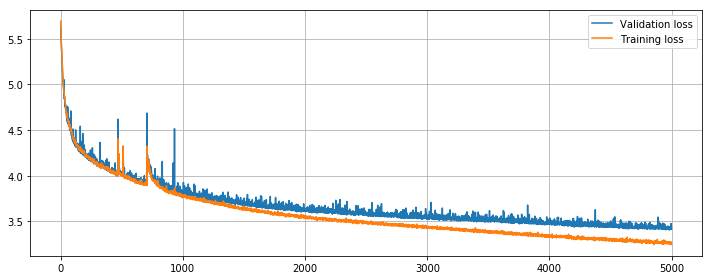

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [16]:
autoencoder.load_weights(weight_path)

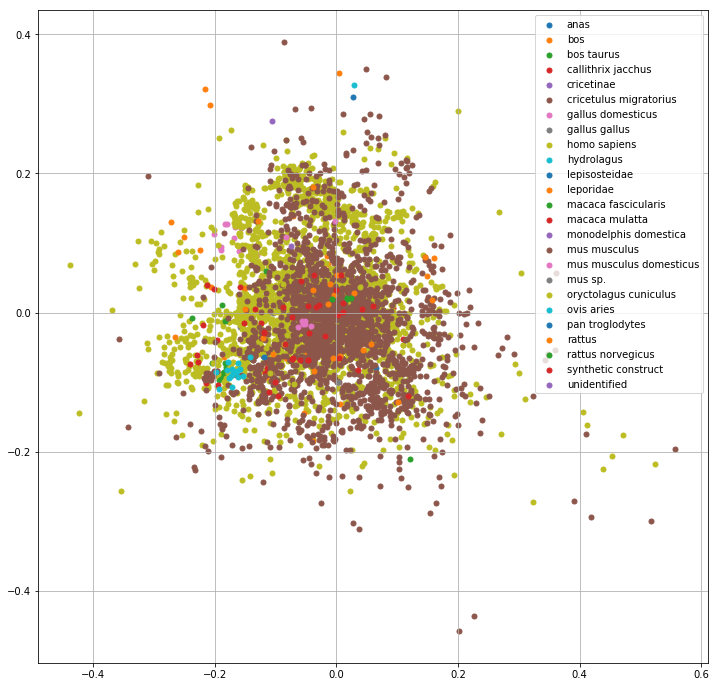

In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals_mask)
labels = le.transform(animals_mask)

unique_labels = np.unique(labels)
len(unique_labels)

c=sns.color_palette(n_colors=25)

f,ax = plt.subplots(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', c=c[x],label=le.classes_[x], s=100)
ax.legend()
leg = ax.get_legend()
for i, x in enumerate(leg.legendHandles):
    x.set_color(c[i])
ax.grid()

In [18]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
light_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

VH_data_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_data)
VL_data_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_data)

code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

latent_data = pd.DataFrame(code_1, columns=[f"Latent{x}" for x in range(1, 51)], index=fab_collection.names)

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

data = data.join(latent_data)

data.head()

Loading in antibody objects


/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,...,Latent41,Latent42,Latent43,Latent44,Latent45,Latent46,Latent47,Latent48,Latent49,Latent50
P2,64.473820,0.000000,NaN,NaN,0.003523,-0.005681,0.005243,0.051418,0.021670,0.181966,...,0.042600,0.149049,0.031167,-0.085060,-0.122417,0.007230,-0.032724,-0.067047,0.089651,0.107890
P3,73.982970,0.130358,NaN,NaN,0.048295,-0.029499,0.012616,0.045318,0.045699,0.210421,...,0.007334,0.181902,0.091613,-0.067408,-0.161802,0.053480,-0.074275,-0.041463,0.110604,0.061388
P4,64.326010,0.060344,NaN,NaN,-0.212363,-0.034255,0.121332,-0.017056,0.090313,0.109553,...,0.055115,-0.119031,-0.413384,-0.187159,-0.031011,-0.118497,0.125994,-0.103432,-0.050610,0.157095
P6,74.192370,0.036953,NaN,NaN,-0.089274,-0.078399,-0.021633,-0.020640,-0.035128,-0.030462,...,-0.006228,-0.086683,-0.087677,0.124390,0.009179,-0.131636,0.191119,-0.047083,-0.061675,-0.055586
P9,72.899025,0.085337,NaN,NaN,-0.232276,0.012704,0.013416,-0.142749,0.097472,0.099610,...,0.029664,-0.143968,-0.455162,-0.001830,0.037824,-0.108287,0.086458,-0.026382,-0.040677,0.037382


In [19]:
X = data[[x for x in data.columns if 'Latent' in x]].as_matrix()

/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [20]:
norm_variance = [np.var(X[:, x] / abs(np.mean(X[:,x]))) for x in range(X.shape[1])]

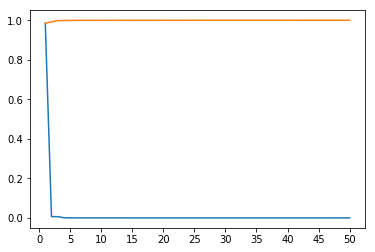

In [21]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

ax.plot(range(1, 51), [norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]])
ax.plot(range(1, 51), np.cumsum([norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]]))

In [23]:
np.argsort(norm_variance)[::-1]

array([40, 41,  2,  6, 20, 48, 47, 38,  3, 49, 13, 22, 43, 30, 31,  1,  8,
        9, 18, 45, 21, 28, 32, 36, 10, 46, 15, 27, 14, 17, 23, 44, 42, 39,
       29,  4, 35,  7,  0, 24,  5, 37, 12, 26, 34, 25, 11, 19, 33, 16])

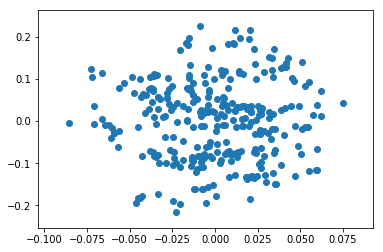

In [24]:
plt.scatter(X[:,40], X[:,41])

In [ ]:
X=X[:, np.argsort(norm_variance)[::-1]][:, :2]